In [4]:
!tar -xvf ff5da6d6ecae486bb294aeaf5ee8f8a1.tar.gz

Streaming output truncated to the last 5000 lines.
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00019.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00000.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00017.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00010.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00014.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00013.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00005.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00019.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00009.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00007.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/depth_00001.tiff
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/rgba_00021.png
ff5da6d6ecae486bb294aeaf5ee8f8a1/camera_0001/obj_0002/segmentation_00000.

# Libraries

In [49]:
# Core libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch utilities
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# Progress
from tqdm import tqdm

# Task

In [5]:
class ModalToAmodalRGBDataset(Dataset):
    def __init__(self, root_dir, camera_name="camera_0001", size=(256, 256)):
        self.root_dir = Path(root_dir)
        self.size = size
        self.samples = []

        camera_path = self.root_dir / camera_name
        obj_paths = sorted(camera_path.glob("obj_*"))

        if not obj_paths:
            raise ValueError(f"No objects found in {camera_path}")

        num_frames = len(list(obj_paths[0].glob("rgba_*.png")))
        for frame_id in range(num_frames):
            frame_str = f"{frame_id:05d}"
            for obj_path in obj_paths:
                self.samples.append({
                    "object_path": obj_path,
                    "frame_id": frame_str
                })

        self.resize = transforms.Resize(self.size)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        obj_path = sample["object_path"]
        frame_id = sample["frame_id"]

        scene_rgb = Image.open(obj_path / f"rgba_{frame_id}.png").convert("RGB")
        scene_seg = np.array(Image.open(obj_path / f"segmentation_{frame_id}.png"))

        obj_mask = scene_seg.astype(bool)
        scene_overlap = scene_seg[obj_mask]
        if scene_overlap.size == 0:
            return self.__getitem__((idx + 1) % len(self))

        labels, counts = np.unique(scene_overlap, return_counts=True)
        object_label = labels[np.argmax(counts)]
        amodal_mask_np = (scene_seg == object_label).astype(np.float32)
        amodal_mask_tensor = torch.from_numpy(amodal_mask_np).unsqueeze(0)

        scene_rgb_tensor = transforms.ToTensor()(scene_rgb)
        masked_rgb = scene_rgb_tensor * amodal_mask_tensor
        masked_seg_rgb = amodal_mask_tensor.repeat(3, 1, 1)

        input_tensor = torch.cat([amodal_mask_tensor, masked_rgb, masked_seg_rgb], dim=0)

        target_rgb = Image.open(obj_path / f"rgba_{frame_id}.png").convert("RGB")
        target_tensor = transforms.ToTensor()(target_rgb)

        input_tensor = self.resize(input_tensor)
        target_tensor = self.resize(target_tensor)

        return input_tensor, target_tensor


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=7, out_channels=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        # Optional: initialize bias to small positive value
        nn.init.constant_(self.final_conv.bias, 0.1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out = self.final_conv(d1)   # Final RGB prediction (3 channels)
        return out  #  correct output


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Total number of samples
dataset = ModalToAmodalRGBDataset(
    root_dir="/content/ff5da6d6ecae486bb294aeaf5ee8f8a1",
    camera_name="camera_0001"
)

# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model = UNet(in_channels=7, out_channels=3).to(device)
#pos_weight = torch.tensor([100.0]).to(device)  # You can tune 100.0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [24]:
x, y = next(iter(train_loader))
print("Input mean:", x.mean().item())
print("Target mean:", y.mean().item())

model.eval()
with torch.no_grad():
    pred = model(x.to(device))
print("Initial pred mean:", pred.mean().item())

print("Final layer weights mean:", model.final_conv.weight.mean().item())

for inputs, targets in train_loader:
    min_val = targets.min().item()
    max_val = targets.max().item()
    in_range = targets.ge(0).all() and targets.le(1).all()

    print("🔍 Target Range Check")
    print(f"→ Min pixel value: {min_val:.6f}")
    print(f"→ Max pixel value: {max_val:.6f}")
    print(f"→ All values in [0, 1]? {' Yes' if in_range else '❌ No'}")
    break  # Remove this line if you want to check more batches


Input mean: 0.02165488339960575
Target mean: 0.014785791747272015
Initial pred mean: -0.4235782027244568
Final layer weights mean: 0.00019453435379546136
🔍 Target Range Check
→ Min pixel value: 0.000000
→ Max pixel value: 0.854902
→ All values in [0, 1]?  Yes


In [11]:
#test

# Set model to evaluation mode and test initial prediction
model.eval()
x, y = next(iter(train_loader))
with torch.no_grad():
    logits = model(x.to(device))  # Output before activation
    pred = torch.relu(logits)     # Apply ReLU activation

print("Initial pred mean:", pred.mean().item())
print(f"Logits mean: {logits.mean().item():.4f}, Logits min: {logits.min().item():.4f}")

# Start training
model.train()
criterion = torch.nn.MSELoss()
epochs = 15

for epoch in range(epochs):
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in loop:
        inputs, targets = batch                # Both from dataset
        inputs = inputs.to(device)             # Shape: [B, 7, H, W]
        targets = targets.to(device)           # Shape: [B, 3, H, W]

        logits = model(inputs)                 # Output before activation: [B, 3, H, W]
        outputs = torch.relu(logits)           # Clamp to [0, ∞)

        loss = criterion(outputs, targets)     # Loss between [B, 3, H, W] tensors

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        with torch.no_grad():
            print(f"Pred mean: {outputs.mean().item():.4f}, Target mean: {targets.mean().item():.4f}")

    print(f"Epoch {epoch+1} completed. Avg Loss: {running_loss / len(train_loader):.4f}")

# Save model
torch.save(model.state_dict(), "unet_task1_2.pth")
print("Model saved.")


Initial pred mean: 0.10898204892873764
Logits mean: 0.1090, Logits min: 0.0901


Epoch 1/15:   2%|▏         | 1/46 [00:00<00:31,  1.45it/s, loss=0.0177]

Pred mean: 0.1090, Target mean: 0.0172


Epoch 1/15:   4%|▍         | 2/46 [00:01<00:24,  1.81it/s, loss=0.023]

Pred mean: 0.1065, Target mean: 0.0334


Epoch 1/15:   7%|▋         | 3/46 [00:01<00:21,  2.00it/s, loss=0.0138]

Pred mean: 0.1041, Target mean: 0.0102


Epoch 1/15:   9%|▊         | 4/46 [00:02<00:20,  2.08it/s, loss=0.0117]

Pred mean: 0.1017, Target mean: 0.0066


Epoch 1/15:  11%|█         | 5/46 [00:02<00:18,  2.16it/s, loss=0.0205]

Pred mean: 0.0997, Target mean: 0.0273


Epoch 1/15:  13%|█▎        | 6/46 [00:02<00:18,  2.21it/s, loss=0.0177]

Pred mean: 0.0975, Target mean: 0.0260


Epoch 1/15:  15%|█▌        | 7/46 [00:03<00:17,  2.24it/s, loss=0.0128]

Pred mean: 0.0948, Target mean: 0.0131


Epoch 1/15:  17%|█▋        | 8/46 [00:03<00:16,  2.25it/s, loss=0.0113]

Pred mean: 0.0923, Target mean: 0.0113


Epoch 1/15:  20%|█▉        | 9/46 [00:04<00:16,  2.27it/s, loss=0.0169]

Pred mean: 0.0903, Target mean: 0.0229


Epoch 1/15:  22%|██▏       | 10/46 [00:04<00:15,  2.28it/s, loss=0.0112]

Pred mean: 0.0874, Target mean: 0.0129


Epoch 1/15:  24%|██▍       | 11/46 [00:05<00:15,  2.29it/s, loss=0.0099]

Pred mean: 0.0847, Target mean: 0.0110


Epoch 1/15:  26%|██▌       | 12/46 [00:05<00:14,  2.29it/s, loss=0.0186]

Pred mean: 0.0837, Target mean: 0.0330


Epoch 1/15:  28%|██▊       | 13/46 [00:05<00:14,  2.29it/s, loss=0.0111]

Pred mean: 0.0804, Target mean: 0.0170


Epoch 1/15:  30%|███       | 14/46 [00:06<00:13,  2.30it/s, loss=0.00961]

Pred mean: 0.0775, Target mean: 0.0131


Epoch 1/15:  33%|███▎      | 15/46 [00:06<00:13,  2.30it/s, loss=0.00793]

Pred mean: 0.0744, Target mean: 0.0090


Epoch 1/15:  35%|███▍      | 16/46 [00:07<00:13,  2.29it/s, loss=0.00803]

Pred mean: 0.0720, Target mean: 0.0124


Epoch 1/15:  37%|███▋      | 17/46 [00:07<00:12,  2.29it/s, loss=0.00944]

Pred mean: 0.0692, Target mean: 0.0165


Epoch 1/15:  39%|███▉      | 18/46 [00:08<00:12,  2.29it/s, loss=0.0134]

Pred mean: 0.0674, Target mean: 0.0261


Epoch 1/15:  41%|████▏     | 19/46 [00:08<00:11,  2.30it/s, loss=0.00693]

Pred mean: 0.0622, Target mean: 0.0132


Epoch 1/15:  43%|████▎     | 20/46 [00:09<00:11,  2.27it/s, loss=0.0123]

Pred mean: 0.0605, Target mean: 0.0264


Epoch 1/15:  46%|████▌     | 21/46 [00:09<00:11,  2.26it/s, loss=0.00513]

Pred mean: 0.0538, Target mean: 0.0105


Epoch 1/15:  48%|████▊     | 22/46 [00:09<00:10,  2.25it/s, loss=0.0109]

Pred mean: 0.0521, Target mean: 0.0261


Epoch 1/15:  50%|█████     | 23/46 [00:10<00:10,  2.22it/s, loss=0.00393]

Pred mean: 0.0441, Target mean: 0.0112


Epoch 1/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.22it/s, loss=0.0259]

Pred mean: 0.0549, Target mean: 0.0768


Epoch 1/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.24it/s, loss=0.00344]

Pred mean: 0.0301, Target mean: 0.0134


Epoch 1/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.25it/s, loss=0.00199]

Pred mean: 0.0189, Target mean: 0.0090


Epoch 1/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.26it/s, loss=0.00204]

Pred mean: 0.0130, Target mean: 0.0105


Epoch 1/15:  61%|██████    | 28/46 [00:12<00:07,  2.27it/s, loss=0.00215]

Pred mean: 0.0061, Target mean: 0.0096


Epoch 1/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.28it/s, loss=0.00618]

Pred mean: 0.0125, Target mean: 0.0266


Epoch 1/15:  65%|██████▌   | 30/46 [00:13<00:06,  2.29it/s, loss=0.0024]

Pred mean: 0.0064, Target mean: 0.0125


Epoch 1/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.30it/s, loss=0.00119]

Pred mean: 0.0047, Target mean: 0.0089


Epoch 1/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.29it/s, loss=0.00649]

Pred mean: 0.0236, Target mean: 0.0398


Epoch 1/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.30it/s, loss=0.00211]

Pred mean: 0.0097, Target mean: 0.0167


Epoch 1/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.31it/s, loss=0.00139]

Pred mean: 0.0062, Target mean: 0.0106


Epoch 1/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.31it/s, loss=0.00129]

Pred mean: 0.0100, Target mean: 0.0136


Epoch 1/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.31it/s, loss=0.00125]

Pred mean: 0.0088, Target mean: 0.0123


Epoch 1/15:  80%|████████  | 37/46 [00:16<00:03,  2.31it/s, loss=0.00161]

Pred mean: 0.0144, Target mean: 0.0184


Epoch 1/15:  83%|████████▎ | 38/46 [00:16<00:03,  2.31it/s, loss=0.000846]

Pred mean: 0.0101, Target mean: 0.0114


Epoch 1/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.31it/s, loss=0.00244]

Pred mean: 0.0313, Target mean: 0.0320


Epoch 1/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.30it/s, loss=0.00127]

Pred mean: 0.0153, Target mean: 0.0167


Epoch 1/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.31it/s, loss=0.00105]

Pred mean: 0.0148, Target mean: 0.0146


Epoch 1/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.29it/s, loss=0.00122]

Pred mean: 0.0157, Target mean: 0.0139


Epoch 1/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.30it/s, loss=0.00211]

Pred mean: 0.0311, Target mean: 0.0290


Epoch 1/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.30it/s, loss=0.00229]

Pred mean: 0.0322, Target mean: 0.0305


Epoch 1/15:  98%|█████████▊| 45/46 [00:19<00:00,  2.30it/s, loss=0.00206]

Pred mean: 0.0350, Target mean: 0.0346


Pred mean: 0.0058, Target mean: 0.0068
Epoch 1 completed. Avg Loss: 0.0078


Epoch 2/15:   2%|▏         | 1/46 [00:00<00:19,  2.27it/s, loss=0.00108]

Pred mean: 0.0206, Target mean: 0.0232


Epoch 2/15:   4%|▍         | 2/46 [00:00<00:19,  2.24it/s, loss=0.000799]

Pred mean: 0.0134, Target mean: 0.0135


Epoch 2/15:   7%|▋         | 3/46 [00:01<00:19,  2.23it/s, loss=0.00439]

Pred mean: 0.0601, Target mean: 0.0586


Epoch 2/15:   9%|▊         | 4/46 [00:01<00:18,  2.24it/s, loss=0.000663]

Pred mean: 0.0092, Target mean: 0.0107


Epoch 2/15:  11%|█         | 5/46 [00:02<00:18,  2.23it/s, loss=0.00096]

Pred mean: 0.0128, Target mean: 0.0126


Epoch 2/15:  13%|█▎        | 6/46 [00:02<00:18,  2.22it/s, loss=0.000832]

Pred mean: 0.0111, Target mean: 0.0139


Epoch 2/15:  15%|█▌        | 7/46 [00:03<00:17,  2.25it/s, loss=0.00193]

Pred mean: 0.0265, Target mean: 0.0287


Epoch 2/15:  17%|█▋        | 8/46 [00:03<00:16,  2.27it/s, loss=0.000635]

Pred mean: 0.0066, Target mean: 0.0086


Epoch 2/15:  20%|█▉        | 9/46 [00:03<00:16,  2.28it/s, loss=0.00118]

Pred mean: 0.0132, Target mean: 0.0146


Epoch 2/15:  22%|██▏       | 10/46 [00:04<00:15,  2.29it/s, loss=0.00114]

Pred mean: 0.0146, Target mean: 0.0166


Epoch 2/15:  24%|██▍       | 11/46 [00:04<00:15,  2.29it/s, loss=0.000775]

Pred mean: 0.0092, Target mean: 0.0116


Epoch 2/15:  26%|██▌       | 12/46 [00:05<00:14,  2.29it/s, loss=0.00188]

Pred mean: 0.0263, Target mean: 0.0286


Epoch 2/15:  28%|██▊       | 13/46 [00:05<00:14,  2.30it/s, loss=0.000653]

Pred mean: 0.0099, Target mean: 0.0123


Epoch 2/15:  30%|███       | 14/46 [00:06<00:13,  2.30it/s, loss=0.0011]

Pred mean: 0.0147, Target mean: 0.0157


Epoch 2/15:  33%|███▎      | 15/46 [00:06<00:13,  2.29it/s, loss=0.00285]

Pred mean: 0.0459, Target mean: 0.0475


Epoch 2/15:  35%|███▍      | 16/46 [00:07<00:13,  2.30it/s, loss=0.000547]

Pred mean: 0.0079, Target mean: 0.0101


Epoch 2/15:  37%|███▋      | 17/46 [00:07<00:12,  2.30it/s, loss=0.00116]

Pred mean: 0.0195, Target mean: 0.0215


Epoch 2/15:  39%|███▉      | 18/46 [00:07<00:12,  2.30it/s, loss=0.000993]

Pred mean: 0.0147, Target mean: 0.0160


Epoch 2/15:  41%|████▏     | 19/46 [00:08<00:11,  2.30it/s, loss=0.00101]

Pred mean: 0.0128, Target mean: 0.0113


Epoch 2/15:  43%|████▎     | 20/46 [00:08<00:11,  2.30it/s, loss=0.000499]

Pred mean: 0.0101, Target mean: 0.0112


Epoch 2/15:  46%|████▌     | 21/46 [00:09<00:10,  2.30it/s, loss=0.00068]

Pred mean: 0.0130, Target mean: 0.0135


Epoch 2/15:  48%|████▊     | 22/46 [00:09<00:10,  2.30it/s, loss=0.000584]

Pred mean: 0.0125, Target mean: 0.0136


Epoch 2/15:  50%|█████     | 23/46 [00:10<00:10,  2.29it/s, loss=0.00265]

Pred mean: 0.0420, Target mean: 0.0434


Epoch 2/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.29it/s, loss=0.000611]

Pred mean: 0.0106, Target mean: 0.0118


Epoch 2/15:  54%|█████▍    | 25/46 [00:10<00:09,  2.28it/s, loss=0.00052]

Pred mean: 0.0095, Target mean: 0.0116


Epoch 2/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.28it/s, loss=0.00163]

Pred mean: 0.0242, Target mean: 0.0255


Epoch 2/15:  59%|█████▊    | 27/46 [00:11<00:08,  2.27it/s, loss=0.00159]

Pred mean: 0.0290, Target mean: 0.0299


Epoch 2/15:  61%|██████    | 28/46 [00:12<00:07,  2.28it/s, loss=0.000443]

Pred mean: 0.0072, Target mean: 0.0091


Epoch 2/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.28it/s, loss=0.00163]

Pred mean: 0.0309, Target mean: 0.0313


Epoch 2/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.26it/s, loss=0.000715]

Pred mean: 0.0154, Target mean: 0.0157


Epoch 2/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.25it/s, loss=0.00148]

Pred mean: 0.0264, Target mean: 0.0277


Epoch 2/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.23it/s, loss=0.000473]

Pred mean: 0.0092, Target mean: 0.0100


Epoch 2/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.23it/s, loss=0.00072]

Pred mean: 0.0144, Target mean: 0.0144


Epoch 2/15:  74%|███████▍  | 34/46 [00:14<00:05,  2.22it/s, loss=0.00245]

Pred mean: 0.0460, Target mean: 0.0472


Epoch 2/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.24it/s, loss=0.000421]

Pred mean: 0.0080, Target mean: 0.0101


Epoch 2/15:  78%|███████▊  | 36/46 [00:15<00:04,  2.25it/s, loss=0.000889]

Pred mean: 0.0158, Target mean: 0.0167


Epoch 2/15:  80%|████████  | 37/46 [00:16<00:03,  2.26it/s, loss=0.00148]

Pred mean: 0.0291, Target mean: 0.0286


Epoch 2/15:  83%|████████▎ | 38/46 [00:16<00:03,  2.27it/s, loss=0.000607]

Pred mean: 0.0091, Target mean: 0.0110


Epoch 2/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.26it/s, loss=0.00125]

Pred mean: 0.0199, Target mean: 0.0227


Epoch 2/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.27it/s, loss=0.000447]

Pred mean: 0.0085, Target mean: 0.0108


Epoch 2/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.28it/s, loss=0.000397]

Pred mean: 0.0075, Target mean: 0.0097


Epoch 2/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.27it/s, loss=0.00137]

Pred mean: 0.0294, Target mean: 0.0307


Epoch 2/15:  93%|█████████▎| 43/46 [00:18<00:01,  2.28it/s, loss=0.000528]

Pred mean: 0.0115, Target mean: 0.0137


Epoch 2/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.28it/s, loss=0.000412]

Pred mean: 0.0093, Target mean: 0.0108


Epoch 2/15:  98%|█████████▊| 45/46 [00:19<00:00,  2.27it/s, loss=0.000522]

Pred mean: 0.0091, Target mean: 0.0110


Pred mean: 0.0064, Target mean: 0.0078
Epoch 2 completed. Avg Loss: 0.0011


Epoch 3/15:   2%|▏         | 1/46 [00:00<00:20,  2.15it/s, loss=0.000431]

Pred mean: 0.0095, Target mean: 0.0108


Epoch 3/15:   4%|▍         | 2/46 [00:00<00:20,  2.18it/s, loss=0.000411]

Pred mean: 0.0101, Target mean: 0.0112


Epoch 3/15:   7%|▋         | 3/46 [00:01<00:19,  2.21it/s, loss=0.00123]

Pred mean: 0.0226, Target mean: 0.0231


Epoch 3/15:   9%|▊         | 4/46 [00:01<00:18,  2.23it/s, loss=0.000503]

Pred mean: 0.0123, Target mean: 0.0129


Epoch 3/15:  11%|█         | 5/46 [00:02<00:18,  2.25it/s, loss=0.000207]

Pred mean: 0.0047, Target mean: 0.0062


Epoch 3/15:  13%|█▎        | 6/46 [00:02<00:17,  2.25it/s, loss=0.000367]

Pred mean: 0.0084, Target mean: 0.0095


Epoch 3/15:  15%|█▌        | 7/46 [00:03<00:17,  2.24it/s, loss=0.000245]

Pred mean: 0.0059, Target mean: 0.0073


Epoch 3/15:  17%|█▋        | 8/46 [00:03<00:17,  2.21it/s, loss=0.000384]

Pred mean: 0.0106, Target mean: 0.0128


Epoch 3/15:  20%|█▉        | 9/46 [00:04<00:17,  2.06it/s, loss=0.00314]

Pred mean: 0.0539, Target mean: 0.0548


Epoch 3/15:  22%|██▏       | 10/46 [00:04<00:17,  2.11it/s, loss=0.000485]

Pred mean: 0.0156, Target mean: 0.0172


Epoch 3/15:  24%|██▍       | 11/46 [00:05<00:16,  2.14it/s, loss=0.000484]

Pred mean: 0.0126, Target mean: 0.0140


Epoch 3/15:  26%|██▌       | 12/46 [00:05<00:15,  2.15it/s, loss=0.00156]

Pred mean: 0.0419, Target mean: 0.0442


Epoch 3/15:  28%|██▊       | 13/46 [00:05<00:15,  2.17it/s, loss=0.000916]

Pred mean: 0.0222, Target mean: 0.0230


Epoch 3/15:  30%|███       | 14/46 [00:06<00:14,  2.18it/s, loss=0.000477]

Pred mean: 0.0132, Target mean: 0.0151


Epoch 3/15:  33%|███▎      | 15/46 [00:06<00:14,  2.17it/s, loss=0.00035]

Pred mean: 0.0098, Target mean: 0.0110


Epoch 3/15:  35%|███▍      | 16/46 [00:07<00:13,  2.17it/s, loss=0.00123]

Pred mean: 0.0303, Target mean: 0.0318


Epoch 3/15:  37%|███▋      | 17/46 [00:07<00:13,  2.19it/s, loss=0.000428]

Pred mean: 0.0106, Target mean: 0.0126


Epoch 3/15:  39%|███▉      | 18/46 [00:08<00:12,  2.20it/s, loss=0.000473]

Pred mean: 0.0193, Target mean: 0.0214


Epoch 3/15:  41%|████▏     | 19/46 [00:08<00:12,  2.21it/s, loss=0.000452]

Pred mean: 0.0143, Target mean: 0.0161


Epoch 3/15:  43%|████▎     | 20/46 [00:09<00:12,  2.14it/s, loss=0.000284]

Pred mean: 0.0065, Target mean: 0.0083


Epoch 3/15:  46%|████▌     | 21/46 [00:09<00:11,  2.17it/s, loss=0.000325]

Pred mean: 0.0089, Target mean: 0.0105


Epoch 3/15:  48%|████▊     | 22/46 [00:10<00:10,  2.19it/s, loss=0.00029]

Pred mean: 0.0115, Target mean: 0.0130


Epoch 3/15:  50%|█████     | 23/46 [00:10<00:10,  2.20it/s, loss=0.000331]

Pred mean: 0.0167, Target mean: 0.0175


Epoch 3/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.22it/s, loss=0.00031]

Pred mean: 0.0150, Target mean: 0.0163


Epoch 3/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.22it/s, loss=0.000983]

Pred mean: 0.0236, Target mean: 0.0253


Epoch 3/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.23it/s, loss=0.000275]

Pred mean: 0.0129, Target mean: 0.0150


Epoch 3/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.23it/s, loss=0.00127]

Pred mean: 0.0290, Target mean: 0.0307


Epoch 3/15:  61%|██████    | 28/46 [00:12<00:08,  2.23it/s, loss=0.000393]

Pred mean: 0.0163, Target mean: 0.0180


Epoch 3/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.23it/s, loss=0.00104]

Pred mean: 0.0279, Target mean: 0.0287


Epoch 3/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.22it/s, loss=0.000838]

Pred mean: 0.0231, Target mean: 0.0247


Epoch 3/15:  67%|██████▋   | 31/46 [00:14<00:06,  2.23it/s, loss=0.000285]

Pred mean: 0.0084, Target mean: 0.0100


Epoch 3/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.23it/s, loss=0.000203]

Pred mean: 0.0096, Target mean: 0.0113


Epoch 3/15:  72%|███████▏  | 33/46 [00:15<00:05,  2.23it/s, loss=0.000242]

Pred mean: 0.0073, Target mean: 0.0090


Epoch 3/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.24it/s, loss=0.000365]

Pred mean: 0.0149, Target mean: 0.0164


Epoch 3/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.24it/s, loss=0.000288]

Pred mean: 0.0081, Target mean: 0.0095


Epoch 3/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.23it/s, loss=0.000287]

Pred mean: 0.0132, Target mean: 0.0145


Epoch 3/15:  80%|████████  | 37/46 [00:16<00:04,  2.16it/s, loss=0.00101]

Pred mean: 0.0254, Target mean: 0.0264


Epoch 3/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.16it/s, loss=0.000297]

Pred mean: 0.0168, Target mean: 0.0188


Epoch 3/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.15it/s, loss=0.000853]

Pred mean: 0.0238, Target mean: 0.0259


Epoch 3/15:  87%|████████▋ | 40/46 [00:18<00:02,  2.13it/s, loss=0.00094]

Pred mean: 0.0253, Target mean: 0.0270


Epoch 3/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.01it/s, loss=0.000976]

Pred mean: 0.0269, Target mean: 0.0280


Epoch 3/15:  91%|█████████▏| 42/46 [00:19<00:01,  2.01it/s, loss=0.000389]

Pred mean: 0.0193, Target mean: 0.0208


Epoch 3/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.07it/s, loss=0.000983]

Pred mean: 0.0259, Target mean: 0.0274


Epoch 3/15:  96%|█████████▌| 44/46 [00:20<00:00,  2.11it/s, loss=0.000406]

Pred mean: 0.0100, Target mean: 0.0115


Epoch 3/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.14it/s, loss=0.000948]

Pred mean: 0.0294, Target mean: 0.0313


Pred mean: 0.0388, Target mean: 0.0405
Epoch 3 completed. Avg Loss: 0.0006


Epoch 4/15:   2%|▏         | 1/46 [00:00<00:20,  2.19it/s, loss=0.000324]

Pred mean: 0.0103, Target mean: 0.0116


Epoch 4/15:   4%|▍         | 2/46 [00:00<00:19,  2.21it/s, loss=0.000819]

Pred mean: 0.0210, Target mean: 0.0217


Epoch 4/15:   7%|▋         | 3/46 [00:01<00:20,  2.13it/s, loss=0.000385]

Pred mean: 0.0176, Target mean: 0.0190


Epoch 4/15:   9%|▊         | 4/46 [00:01<00:19,  2.17it/s, loss=0.000862]

Pred mean: 0.0230, Target mean: 0.0247


Epoch 4/15:  11%|█         | 5/46 [00:02<00:18,  2.19it/s, loss=0.000187]

Pred mean: 0.0061, Target mean: 0.0079


Epoch 4/15:  13%|█▎        | 6/46 [00:02<00:18,  2.21it/s, loss=0.000362]

Pred mean: 0.0142, Target mean: 0.0166


Epoch 4/15:  15%|█▌        | 7/46 [00:03<00:17,  2.21it/s, loss=0.000269]

Pred mean: 0.0108, Target mean: 0.0128


Epoch 4/15:  17%|█▋        | 8/46 [00:03<00:17,  2.22it/s, loss=0.000204]

Pred mean: 0.0097, Target mean: 0.0113


Epoch 4/15:  20%|█▉        | 9/46 [00:04<00:16,  2.22it/s, loss=0.000169]

Pred mean: 0.0102, Target mean: 0.0114


Epoch 4/15:  22%|██▏       | 10/46 [00:04<00:16,  2.23it/s, loss=0.000195]

Pred mean: 0.0106, Target mean: 0.0115


Epoch 4/15:  24%|██▍       | 11/46 [00:04<00:15,  2.23it/s, loss=0.000952]

Pred mean: 0.0347, Target mean: 0.0343


Epoch 4/15:  26%|██▌       | 12/46 [00:05<00:15,  2.23it/s, loss=0.0011]

Pred mean: 0.0301, Target mean: 0.0320


Epoch 4/15:  28%|██▊       | 13/46 [00:05<00:14,  2.22it/s, loss=0.000823]

Pred mean: 0.0221, Target mean: 0.0256


Epoch 4/15:  30%|███       | 14/46 [00:06<00:14,  2.21it/s, loss=0.000254]

Pred mean: 0.0098, Target mean: 0.0122


Epoch 4/15:  33%|███▎      | 15/46 [00:06<00:13,  2.22it/s, loss=0.00088]

Pred mean: 0.0251, Target mean: 0.0276


Epoch 4/15:  35%|███▍      | 16/46 [00:07<00:13,  2.22it/s, loss=0.000608]

Pred mean: 0.0267, Target mean: 0.0279


Epoch 4/15:  37%|███▋      | 17/46 [00:07<00:13,  2.22it/s, loss=0.000756]

Pred mean: 0.0212, Target mean: 0.0217


Epoch 4/15:  39%|███▉      | 18/46 [00:08<00:12,  2.23it/s, loss=0.000259]

Pred mean: 0.0091, Target mean: 0.0103


Epoch 4/15:  41%|████▏     | 19/46 [00:08<00:12,  2.22it/s, loss=0.000356]

Pred mean: 0.0135, Target mean: 0.0146


Epoch 4/15:  43%|████▎     | 20/46 [00:09<00:11,  2.20it/s, loss=0.000615]

Pred mean: 0.0241, Target mean: 0.0253


Epoch 4/15:  46%|████▌     | 21/46 [00:09<00:11,  2.19it/s, loss=0.000323]

Pred mean: 0.0111, Target mean: 0.0128


Epoch 4/15:  48%|████▊     | 22/46 [00:09<00:10,  2.18it/s, loss=0.000693]

Pred mean: 0.0223, Target mean: 0.0245


Epoch 4/15:  50%|█████     | 23/46 [00:10<00:10,  2.18it/s, loss=0.000695]

Pred mean: 0.0264, Target mean: 0.0287


Epoch 4/15:  52%|█████▏    | 24/46 [00:10<00:10,  2.19it/s, loss=0.000641]

Pred mean: 0.0289, Target mean: 0.0304


Epoch 4/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.21it/s, loss=0.000301]

Pred mean: 0.0162, Target mean: 0.0173


Epoch 4/15:  57%|█████▋    | 26/46 [00:11<00:09,  2.22it/s, loss=0.000254]

Pred mean: 0.0161, Target mean: 0.0169


Epoch 4/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.23it/s, loss=0.000248]

Pred mean: 0.0106, Target mean: 0.0118


Epoch 4/15:  61%|██████    | 28/46 [00:12<00:08,  2.23it/s, loss=0.000248]

Pred mean: 0.0192, Target mean: 0.0204


Epoch 4/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.24it/s, loss=0.000215]

Pred mean: 0.0127, Target mean: 0.0143


Epoch 4/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.24it/s, loss=0.000163]

Pred mean: 0.0114, Target mean: 0.0133


Epoch 4/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.24it/s, loss=0.000837]

Pred mean: 0.0283, Target mean: 0.0310


Epoch 4/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.24it/s, loss=0.000906]

Pred mean: 0.0293, Target mean: 0.0317


Epoch 4/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.24it/s, loss=0.000157]

Pred mean: 0.0111, Target mean: 0.0129


Epoch 4/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.24it/s, loss=0.000118]

Pred mean: 0.0055, Target mean: 0.0071


Epoch 4/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.22it/s, loss=0.000133]

Pred mean: 0.0071, Target mean: 0.0086


Epoch 4/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.19it/s, loss=0.000156]

Pred mean: 0.0112, Target mean: 0.0126


Epoch 4/15:  80%|████████  | 37/46 [00:16<00:04,  2.18it/s, loss=0.00115]

Pred mean: 0.0445, Target mean: 0.0450


Epoch 4/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.21it/s, loss=0.000312]

Pred mean: 0.0166, Target mean: 0.0184


Epoch 4/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.22it/s, loss=0.00021]

Pred mean: 0.0105, Target mean: 0.0125


Epoch 4/15:  87%|████████▋ | 40/46 [00:18<00:02,  2.23it/s, loss=0.000289]

Pred mean: 0.0194, Target mean: 0.0213


Epoch 4/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.24it/s, loss=0.000159]

Pred mean: 0.0116, Target mean: 0.0132


Epoch 4/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.24it/s, loss=0.000124]

Pred mean: 0.0098, Target mean: 0.0112


Epoch 4/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.24it/s, loss=0.000159]

Pred mean: 0.0113, Target mean: 0.0125


Epoch 4/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.23it/s, loss=0.000633]

Pred mean: 0.0293, Target mean: 0.0303


Epoch 4/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.24it/s, loss=0.000547]

Pred mean: 0.0238, Target mean: 0.0256


Pred mean: 0.0118, Target mean: 0.0138
Epoch 4 completed. Avg Loss: 0.0004


Epoch 5/15:   2%|▏         | 1/46 [00:00<00:20,  2.17it/s, loss=0.000262]

Pred mean: 0.0168, Target mean: 0.0195


Epoch 5/15:   4%|▍         | 2/46 [00:00<00:20,  2.18it/s, loss=0.000142]

Pred mean: 0.0074, Target mean: 0.0093


Epoch 5/15:   7%|▋         | 3/46 [00:01<00:19,  2.19it/s, loss=0.000159]

Pred mean: 0.0085, Target mean: 0.0104


Epoch 5/15:   9%|▊         | 4/46 [00:01<00:19,  2.18it/s, loss=0.000378]

Pred mean: 0.0250, Target mean: 0.0267


Epoch 5/15:  11%|█         | 5/46 [00:02<00:18,  2.19it/s, loss=0.000203]

Pred mean: 0.0165, Target mean: 0.0176


Epoch 5/15:  13%|█▎        | 6/46 [00:02<00:18,  2.21it/s, loss=0.000382]

Pred mean: 0.0290, Target mean: 0.0294


Epoch 5/15:  15%|█▌        | 7/46 [00:03<00:17,  2.23it/s, loss=0.000154]

Pred mean: 0.0111, Target mean: 0.0123


Epoch 5/15:  17%|█▋        | 8/46 [00:03<00:16,  2.24it/s, loss=0.000187]

Pred mean: 0.0118, Target mean: 0.0130


Epoch 5/15:  20%|█▉        | 9/46 [00:04<00:16,  2.24it/s, loss=0.000158]

Pred mean: 0.0115, Target mean: 0.0131


Epoch 5/15:  22%|██▏       | 10/46 [00:04<00:16,  2.25it/s, loss=0.000114]

Pred mean: 0.0112, Target mean: 0.0131


Epoch 5/15:  24%|██▍       | 11/46 [00:04<00:15,  2.25it/s, loss=0.000134]

Pred mean: 0.0108, Target mean: 0.0127


Epoch 5/15:  26%|██▌       | 12/46 [00:05<00:15,  2.26it/s, loss=0.000115]

Pred mean: 0.0095, Target mean: 0.0115


Epoch 5/15:  28%|██▊       | 13/46 [00:05<00:14,  2.26it/s, loss=0.000192]

Pred mean: 0.0140, Target mean: 0.0158


Epoch 5/15:  30%|███       | 14/46 [00:06<00:14,  2.26it/s, loss=0.000116]

Pred mean: 0.0102, Target mean: 0.0119


Epoch 5/15:  33%|███▎      | 15/46 [00:06<00:13,  2.26it/s, loss=0.000428]

Pred mean: 0.0244, Target mean: 0.0262


Epoch 5/15:  35%|███▍      | 16/46 [00:07<00:13,  2.26it/s, loss=0.000107]

Pred mean: 0.0049, Target mean: 0.0064


Epoch 5/15:  37%|███▋      | 17/46 [00:07<00:12,  2.27it/s, loss=0.000142]

Pred mean: 0.0142, Target mean: 0.0154


Epoch 5/15:  39%|███▉      | 18/46 [00:08<00:12,  2.27it/s, loss=0.000322]

Pred mean: 0.0225, Target mean: 0.0240


Epoch 5/15:  41%|████▏     | 19/46 [00:08<00:11,  2.26it/s, loss=0.000303]

Pred mean: 0.0281, Target mean: 0.0298


Epoch 5/15:  43%|████▎     | 20/46 [00:08<00:11,  2.25it/s, loss=0.000299]

Pred mean: 0.0213, Target mean: 0.0230


Epoch 5/15:  46%|████▌     | 21/46 [00:09<00:11,  2.21it/s, loss=0.000144]

Pred mean: 0.0124, Target mean: 0.0139


Epoch 5/15:  48%|████▊     | 22/46 [00:09<00:10,  2.19it/s, loss=0.000176]

Pred mean: 0.0126, Target mean: 0.0141


Epoch 5/15:  50%|█████     | 23/46 [00:10<00:10,  2.20it/s, loss=0.000548]

Pred mean: 0.0379, Target mean: 0.0400


Epoch 5/15:  52%|█████▏    | 24/46 [00:10<00:10,  2.17it/s, loss=0.000332]

Pred mean: 0.0265, Target mean: 0.0279


Epoch 5/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.16it/s, loss=0.000146]

Pred mean: 0.0107, Target mean: 0.0121


Epoch 5/15:  57%|█████▋    | 26/46 [00:11<00:09,  2.20it/s, loss=0.000131]

Pred mean: 0.0122, Target mean: 0.0134


Epoch 5/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.21it/s, loss=0.00031]

Pred mean: 0.0257, Target mean: 0.0272


Epoch 5/15:  61%|██████    | 28/46 [00:12<00:08,  2.21it/s, loss=0.00033]

Pred mean: 0.0275, Target mean: 0.0291


Epoch 5/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.21it/s, loss=0.000511]

Pred mean: 0.0428, Target mean: 0.0452


Epoch 5/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.20it/s, loss=0.000234]

Pred mean: 0.0214, Target mean: 0.0231


Epoch 5/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.19it/s, loss=0.000126]

Pred mean: 0.0118, Target mean: 0.0131


Epoch 5/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.20it/s, loss=0.000238]

Pred mean: 0.0243, Target mean: 0.0252


Epoch 5/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.22it/s, loss=0.000313]

Pred mean: 0.0285, Target mean: 0.0295


Epoch 5/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.24it/s, loss=0.000135]

Pred mean: 0.0103, Target mean: 0.0119


Epoch 5/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.24it/s, loss=0.000168]

Pred mean: 0.0154, Target mean: 0.0174


Epoch 5/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.25it/s, loss=9.16e-5]

Pred mean: 0.0071, Target mean: 0.0089


Epoch 5/15:  80%|████████  | 37/46 [00:16<00:04,  2.25it/s, loss=0.000126]

Pred mean: 0.0120, Target mean: 0.0138


Epoch 5/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.26it/s, loss=0.000108]

Pred mean: 0.0109, Target mean: 0.0126


Epoch 5/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.26it/s, loss=0.000271]

Pred mean: 0.0268, Target mean: 0.0284


Epoch 5/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.27it/s, loss=0.000126]

Pred mean: 0.0111, Target mean: 0.0127


Epoch 5/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.27it/s, loss=0.000475]

Pred mean: 0.0444, Target mean: 0.0456


Epoch 5/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.26it/s, loss=0.000105]

Pred mean: 0.0109, Target mean: 0.0125


Epoch 5/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=8.53e-5]

Pred mean: 0.0100, Target mean: 0.0117


Epoch 5/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=0.000156]

Pred mean: 0.0174, Target mean: 0.0193


Epoch 5/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.26it/s, loss=0.00015]

Pred mean: 0.0096, Target mean: 0.0114


Pred mean: 0.0185, Target mean: 0.0201
Epoch 5 completed. Avg Loss: 0.0002


Epoch 6/15:   2%|▏         | 1/46 [00:00<00:19,  2.25it/s, loss=0.000263]

Pred mean: 0.0307, Target mean: 0.0328


Epoch 6/15:   4%|▍         | 2/46 [00:00<00:19,  2.26it/s, loss=0.00013]

Pred mean: 0.0148, Target mean: 0.0162


Epoch 6/15:   7%|▋         | 3/46 [00:01<00:19,  2.21it/s, loss=9.77e-5]

Pred mean: 0.0051, Target mean: 0.0065


Epoch 6/15:   9%|▊         | 4/46 [00:01<00:21,  1.94it/s, loss=0.000126]

Pred mean: 0.0135, Target mean: 0.0148


Epoch 6/15:  11%|█         | 5/46 [00:02<00:19,  2.05it/s, loss=0.000111]

Pred mean: 0.0135, Target mean: 0.0148


Epoch 6/15:  13%|█▎        | 6/46 [00:02<00:18,  2.12it/s, loss=0.000258]

Pred mean: 0.0274, Target mean: 0.0290


Epoch 6/15:  15%|█▌        | 7/46 [00:03<00:18,  2.16it/s, loss=0.000301]

Pred mean: 0.0330, Target mean: 0.0350


Epoch 6/15:  17%|█▋        | 8/46 [00:03<00:17,  2.20it/s, loss=0.000244]

Pred mean: 0.0250, Target mean: 0.0266


Epoch 6/15:  20%|█▉        | 9/46 [00:04<00:16,  2.20it/s, loss=0.000119]

Pred mean: 0.0137, Target mean: 0.0153


Epoch 6/15:  22%|██▏       | 10/46 [00:04<00:16,  2.20it/s, loss=0.000119]

Pred mean: 0.0101, Target mean: 0.0115


Epoch 6/15:  24%|██▍       | 11/46 [00:05<00:16,  2.18it/s, loss=0.000274]

Pred mean: 0.0268, Target mean: 0.0283


Epoch 6/15:  26%|██▌       | 12/46 [00:05<00:16,  2.10it/s, loss=0.000159]

Pred mean: 0.0131, Target mean: 0.0147


Epoch 6/15:  28%|██▊       | 13/46 [00:06<00:15,  2.13it/s, loss=0.000388]

Pred mean: 0.0497, Target mean: 0.0516


Epoch 6/15:  30%|███       | 14/46 [00:06<00:14,  2.17it/s, loss=0.000273]

Pred mean: 0.0227, Target mean: 0.0243


Epoch 6/15:  33%|███▎      | 15/46 [00:06<00:14,  2.19it/s, loss=0.000103]

Pred mean: 0.0102, Target mean: 0.0117


Epoch 6/15:  35%|███▍      | 16/46 [00:07<00:13,  2.22it/s, loss=0.000127]

Pred mean: 0.0124, Target mean: 0.0138


Epoch 6/15:  37%|███▋      | 17/46 [00:07<00:12,  2.24it/s, loss=0.000141]

Pred mean: 0.0118, Target mean: 0.0133


Epoch 6/15:  39%|███▉      | 18/46 [00:08<00:12,  2.25it/s, loss=0.000179]

Pred mean: 0.0224, Target mean: 0.0240


Epoch 6/15:  41%|████▏     | 19/46 [00:08<00:11,  2.26it/s, loss=0.00011]

Pred mean: 0.0168, Target mean: 0.0186


Epoch 6/15:  43%|████▎     | 20/46 [00:09<00:11,  2.27it/s, loss=0.0001]

Pred mean: 0.0052, Target mean: 0.0069


Epoch 6/15:  46%|████▌     | 21/46 [00:09<00:11,  2.27it/s, loss=0.00016]

Pred mean: 0.0201, Target mean: 0.0222


Epoch 6/15:  48%|████▊     | 22/46 [00:10<00:10,  2.27it/s, loss=0.000261]

Pred mean: 0.0261, Target mean: 0.0276


Epoch 6/15:  50%|█████     | 23/46 [00:10<00:10,  2.28it/s, loss=0.000135]

Pred mean: 0.0085, Target mean: 0.0100


Epoch 6/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.28it/s, loss=8.36e-5]

Pred mean: 0.0093, Target mean: 0.0106


Epoch 6/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.28it/s, loss=0.000122]

Pred mean: 0.0086, Target mean: 0.0099


Epoch 6/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.28it/s, loss=0.000126]

Pred mean: 0.0111, Target mean: 0.0125


Epoch 6/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.28it/s, loss=0.000102]

Pred mean: 0.0081, Target mean: 0.0096


Epoch 6/15:  61%|██████    | 28/46 [00:12<00:07,  2.28it/s, loss=0.000401]

Pred mean: 0.0429, Target mean: 0.0453


Epoch 6/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.27it/s, loss=8.93e-5]

Pred mean: 0.0106, Target mean: 0.0124


Epoch 6/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.27it/s, loss=9.23e-5]

Pred mean: 0.0084, Target mean: 0.0100


Epoch 6/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.27it/s, loss=9.87e-5]

Pred mean: 0.0136, Target mean: 0.0149


Epoch 6/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.27it/s, loss=0.000244]

Pred mean: 0.0224, Target mean: 0.0236


Epoch 6/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.27it/s, loss=6.99e-5]

Pred mean: 0.0082, Target mean: 0.0098


Epoch 6/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.28it/s, loss=0.000147]

Pred mean: 0.0116, Target mean: 0.0133


Epoch 6/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.27it/s, loss=0.000122]

Pred mean: 0.0144, Target mean: 0.0163


Epoch 6/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.27it/s, loss=0.000104]

Pred mean: 0.0165, Target mean: 0.0184


Epoch 6/15:  80%|████████  | 37/46 [00:16<00:03,  2.26it/s, loss=0.000252]

Pred mean: 0.0228, Target mean: 0.0245


Epoch 6/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.25it/s, loss=0.000104]

Pred mean: 0.0065, Target mean: 0.0081


Epoch 6/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.25it/s, loss=0.000131]

Pred mean: 0.0120, Target mean: 0.0132


Epoch 6/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.24it/s, loss=0.000261]

Pred mean: 0.0277, Target mean: 0.0286


Epoch 6/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.22it/s, loss=0.00022]

Pred mean: 0.0276, Target mean: 0.0291


Epoch 6/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.19it/s, loss=6.74e-5]

Pred mean: 0.0078, Target mean: 0.0095


Epoch 6/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.06it/s, loss=0.000267]

Pred mean: 0.0260, Target mean: 0.0284


Epoch 6/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.05it/s, loss=9.77e-5]

Pred mean: 0.0070, Target mean: 0.0087


Epoch 6/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.11it/s, loss=0.000377]

Pred mean: 0.0359, Target mean: 0.0376


Pred mean: 0.0131, Target mean: 0.0143
Epoch 6 completed. Avg Loss: 0.0002


Epoch 7/15:   2%|▏         | 1/46 [00:00<00:20,  2.22it/s, loss=0.000141]

Pred mean: 0.0102, Target mean: 0.0115


Epoch 7/15:   4%|▍         | 2/46 [00:00<00:19,  2.25it/s, loss=0.000121]

Pred mean: 0.0117, Target mean: 0.0131


Epoch 7/15:   7%|▋         | 3/46 [00:01<00:19,  2.25it/s, loss=0.00049]

Pred mean: 0.0546, Target mean: 0.0561


Epoch 7/15:   9%|▊         | 4/46 [00:01<00:18,  2.26it/s, loss=7.37e-5]

Pred mean: 0.0079, Target mean: 0.0096


Epoch 7/15:  11%|█         | 5/46 [00:02<00:18,  2.26it/s, loss=0.000103]

Pred mean: 0.0153, Target mean: 0.0172


Epoch 7/15:  13%|█▎        | 6/46 [00:02<00:17,  2.26it/s, loss=0.000199]

Pred mean: 0.0256, Target mean: 0.0279


Epoch 7/15:  15%|█▌        | 7/46 [00:03<00:17,  2.26it/s, loss=0.000107]

Pred mean: 0.0112, Target mean: 0.0129


Epoch 7/15:  17%|█▋        | 8/46 [00:03<00:16,  2.26it/s, loss=0.000101]

Pred mean: 0.0115, Target mean: 0.0128


Epoch 7/15:  20%|█▉        | 9/46 [00:03<00:16,  2.26it/s, loss=0.000129]

Pred mean: 0.0133, Target mean: 0.0144


Epoch 7/15:  22%|██▏       | 10/46 [00:04<00:15,  2.26it/s, loss=0.000237]

Pred mean: 0.0332, Target mean: 0.0337


Epoch 7/15:  24%|██▍       | 11/46 [00:04<00:15,  2.26it/s, loss=0.000117]

Pred mean: 0.0141, Target mean: 0.0158


Epoch 7/15:  26%|██▌       | 12/46 [00:05<00:15,  2.26it/s, loss=0.000119]

Pred mean: 0.0088, Target mean: 0.0106


Epoch 7/15:  28%|██▊       | 13/46 [00:05<00:14,  2.26it/s, loss=0.00011]

Pred mean: 0.0078, Target mean: 0.0098


Epoch 7/15:  30%|███       | 14/46 [00:06<00:14,  2.27it/s, loss=0.000128]

Pred mean: 0.0099, Target mean: 0.0120


Epoch 7/15:  33%|███▎      | 15/46 [00:06<00:13,  2.26it/s, loss=0.000135]

Pred mean: 0.0186, Target mean: 0.0210


Epoch 7/15:  35%|███▍      | 16/46 [00:07<00:13,  2.26it/s, loss=7.88e-5]

Pred mean: 0.0117, Target mean: 0.0132


Epoch 7/15:  37%|███▋      | 17/46 [00:07<00:12,  2.26it/s, loss=0.000159]

Pred mean: 0.0171, Target mean: 0.0180


Epoch 7/15:  39%|███▉      | 18/46 [00:07<00:12,  2.24it/s, loss=0.000118]

Pred mean: 0.0095, Target mean: 0.0106


Epoch 7/15:  41%|████▏     | 19/46 [00:08<00:12,  2.22it/s, loss=0.000328]

Pred mean: 0.0446, Target mean: 0.0447


Epoch 7/15:  43%|████▎     | 20/46 [00:08<00:11,  2.21it/s, loss=9.87e-5]

Pred mean: 0.0101, Target mean: 0.0117


Epoch 7/15:  46%|████▌     | 21/46 [00:09<00:11,  2.20it/s, loss=0.000244]

Pred mean: 0.0189, Target mean: 0.0219


Epoch 7/15:  48%|████▊     | 22/46 [00:09<00:10,  2.20it/s, loss=0.000119]

Pred mean: 0.0103, Target mean: 0.0126


Epoch 7/15:  50%|█████     | 23/46 [00:10<00:10,  2.21it/s, loss=0.000274]

Pred mean: 0.0289, Target mean: 0.0315


Epoch 7/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.23it/s, loss=7.94e-5]

Pred mean: 0.0105, Target mean: 0.0119


Epoch 7/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.24it/s, loss=0.000197]

Pred mean: 0.0224, Target mean: 0.0226


Epoch 7/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.24it/s, loss=0.000251]

Pred mean: 0.0232, Target mean: 0.0237


Epoch 7/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.24it/s, loss=0.000258]

Pred mean: 0.0268, Target mean: 0.0279


Epoch 7/15:  61%|██████    | 28/46 [00:12<00:08,  2.24it/s, loss=0.000105]

Pred mean: 0.0079, Target mean: 0.0096


Epoch 7/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.25it/s, loss=0.000125]

Pred mean: 0.0056, Target mean: 0.0075


Epoch 7/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.26it/s, loss=9.41e-5]

Pred mean: 0.0060, Target mean: 0.0081


Epoch 7/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.26it/s, loss=0.000158]

Pred mean: 0.0113, Target mean: 0.0139


Epoch 7/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.26it/s, loss=0.000168]

Pred mean: 0.0118, Target mean: 0.0142


Epoch 7/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.25it/s, loss=0.00036]

Pred mean: 0.0409, Target mean: 0.0432


Epoch 7/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.25it/s, loss=0.000151]

Pred mean: 0.0184, Target mean: 0.0192


Epoch 7/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.25it/s, loss=0.000468]

Pred mean: 0.0426, Target mean: 0.0420


Epoch 7/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.25it/s, loss=0.000104]

Pred mean: 0.0121, Target mean: 0.0132


Epoch 7/15:  80%|████████  | 37/46 [00:16<00:03,  2.25it/s, loss=8.93e-5]

Pred mean: 0.0132, Target mean: 0.0147


Epoch 7/15:  83%|████████▎ | 38/46 [00:16<00:03,  2.25it/s, loss=8.89e-5]

Pred mean: 0.0075, Target mean: 0.0095


Epoch 7/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.25it/s, loss=0.000304]

Pred mean: 0.0236, Target mean: 0.0270


Epoch 7/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.25it/s, loss=9.49e-5]

Pred mean: 0.0097, Target mean: 0.0117


Epoch 7/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.24it/s, loss=0.000243]

Pred mean: 0.0313, Target mean: 0.0333


Epoch 7/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.25it/s, loss=0.000218]

Pred mean: 0.0316, Target mean: 0.0325


Epoch 7/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=0.000128]

Pred mean: 0.0112, Target mean: 0.0123


Epoch 7/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=0.000124]

Pred mean: 0.0142, Target mean: 0.0151


Epoch 7/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.25it/s, loss=0.000119]

Pred mean: 0.0080, Target mean: 0.0093


Pred mean: 0.0109, Target mean: 0.0125
Epoch 7 completed. Avg Loss: 0.0002


Epoch 8/15:   2%|▏         | 1/46 [00:00<00:20,  2.22it/s, loss=0.000238]

Pred mean: 0.0213, Target mean: 0.0230


Epoch 8/15:   4%|▍         | 2/46 [00:00<00:20,  2.20it/s, loss=0.000243]

Pred mean: 0.0337, Target mean: 0.0360


Epoch 8/15:   7%|▋         | 3/46 [00:01<00:19,  2.17it/s, loss=9.27e-5]

Pred mean: 0.0116, Target mean: 0.0135


Epoch 8/15:   9%|▊         | 4/46 [00:01<00:19,  2.17it/s, loss=9.76e-5]

Pred mean: 0.0116, Target mean: 0.0134


Epoch 8/15:  11%|█         | 5/46 [00:02<00:18,  2.20it/s, loss=9.97e-5]

Pred mean: 0.0066, Target mean: 0.0082


Epoch 8/15:  13%|█▎        | 6/46 [00:02<00:18,  2.21it/s, loss=0.000373]

Pred mean: 0.0557, Target mean: 0.0560


Epoch 8/15:  15%|█▌        | 7/46 [00:03<00:17,  2.23it/s, loss=0.000131]

Pred mean: 0.0097, Target mean: 0.0112


Epoch 8/15:  17%|█▋        | 8/46 [00:03<00:16,  2.24it/s, loss=0.000105]

Pred mean: 0.0107, Target mean: 0.0123


Epoch 8/15:  20%|█▉        | 9/46 [00:04<00:16,  2.24it/s, loss=0.000184]

Pred mean: 0.0223, Target mean: 0.0245


Epoch 8/15:  22%|██▏       | 10/46 [00:04<00:16,  2.24it/s, loss=0.000208]

Pred mean: 0.0227, Target mean: 0.0249


Epoch 8/15:  24%|██▍       | 11/46 [00:04<00:15,  2.25it/s, loss=0.000109]

Pred mean: 0.0113, Target mean: 0.0130


Epoch 8/15:  26%|██▌       | 12/46 [00:05<00:15,  2.25it/s, loss=5.77e-5]

Pred mean: 0.0094, Target mean: 0.0110


Epoch 8/15:  28%|██▊       | 13/46 [00:05<00:14,  2.26it/s, loss=0.000132]

Pred mean: 0.0139, Target mean: 0.0153


Epoch 8/15:  30%|███       | 14/46 [00:06<00:14,  2.26it/s, loss=9.81e-5]

Pred mean: 0.0089, Target mean: 0.0104


Epoch 8/15:  33%|███▎      | 15/46 [00:06<00:13,  2.25it/s, loss=8.26e-5]

Pred mean: 0.0088, Target mean: 0.0102


Epoch 8/15:  35%|███▍      | 16/46 [00:07<00:13,  2.25it/s, loss=6.29e-5]

Pred mean: 0.0068, Target mean: 0.0083


Epoch 8/15:  37%|███▋      | 17/46 [00:07<00:12,  2.25it/s, loss=0.000125]

Pred mean: 0.0180, Target mean: 0.0194


Epoch 8/15:  39%|███▉      | 18/46 [00:08<00:12,  2.25it/s, loss=9.02e-5]

Pred mean: 0.0134, Target mean: 0.0151


Epoch 8/15:  41%|████▏     | 19/46 [00:08<00:11,  2.25it/s, loss=0.000158]

Pred mean: 0.0182, Target mean: 0.0200


Epoch 8/15:  43%|████▎     | 20/46 [00:08<00:11,  2.25it/s, loss=0.000232]

Pred mean: 0.0239, Target mean: 0.0257


Epoch 8/15:  46%|████▌     | 21/46 [00:09<00:11,  2.25it/s, loss=0.000224]

Pred mean: 0.0225, Target mean: 0.0243


Epoch 8/15:  48%|████▊     | 22/46 [00:09<00:10,  2.24it/s, loss=0.000193]

Pred mean: 0.0265, Target mean: 0.0280


Epoch 8/15:  50%|█████     | 23/46 [00:10<00:10,  2.25it/s, loss=8.12e-5]

Pred mean: 0.0134, Target mean: 0.0148


Epoch 8/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.25it/s, loss=8.42e-5]

Pred mean: 0.0102, Target mean: 0.0117


Epoch 8/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.25it/s, loss=0.000184]

Pred mean: 0.0253, Target mean: 0.0268


Epoch 8/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.24it/s, loss=7.96e-5]

Pred mean: 0.0104, Target mean: 0.0120


Epoch 8/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.22it/s, loss=0.000369]

Pred mean: 0.0416, Target mean: 0.0434


Epoch 8/15:  61%|██████    | 28/46 [00:12<00:08,  2.21it/s, loss=0.000101]

Pred mean: 0.0109, Target mean: 0.0126


Epoch 8/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.21it/s, loss=0.000243]

Pred mean: 0.0309, Target mean: 0.0325


Epoch 8/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.20it/s, loss=0.000124]

Pred mean: 0.0186, Target mean: 0.0201


Epoch 8/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.19it/s, loss=8.39e-5]

Pred mean: 0.0148, Target mean: 0.0163


Epoch 8/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.21it/s, loss=8.83e-5]

Pred mean: 0.0067, Target mean: 0.0083


Epoch 8/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.22it/s, loss=0.000105]

Pred mean: 0.0118, Target mean: 0.0134


Epoch 8/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.22it/s, loss=9.48e-5]

Pred mean: 0.0119, Target mean: 0.0136


Epoch 8/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.23it/s, loss=0.000149]

Pred mean: 0.0126, Target mean: 0.0143


Epoch 8/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.24it/s, loss=9.8e-5]

Pred mean: 0.0095, Target mean: 0.0112


Epoch 8/15:  80%|████████  | 37/46 [00:16<00:04,  2.24it/s, loss=0.000226]

Pred mean: 0.0236, Target mean: 0.0253


Epoch 8/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.25it/s, loss=0.000123]

Pred mean: 0.0120, Target mean: 0.0137


Epoch 8/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.25it/s, loss=0.000206]

Pred mean: 0.0222, Target mean: 0.0235


Epoch 8/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.24it/s, loss=0.000236]

Pred mean: 0.0345, Target mean: 0.0357


Epoch 8/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.24it/s, loss=0.000193]

Pred mean: 0.0290, Target mean: 0.0307


Epoch 8/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.24it/s, loss=7.02e-5]

Pred mean: 0.0072, Target mean: 0.0088


Epoch 8/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.24it/s, loss=9.7e-5]

Pred mean: 0.0122, Target mean: 0.0140


Epoch 8/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=9.1e-5]

Pred mean: 0.0093, Target mean: 0.0112


Epoch 8/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.25it/s, loss=0.000217]

Pred mean: 0.0276, Target mean: 0.0295


Pred mean: 0.0061, Target mean: 0.0076
Epoch 8 completed. Avg Loss: 0.0001


Epoch 9/15:   2%|▏         | 1/46 [00:00<00:20,  2.22it/s, loss=0.000103]

Pred mean: 0.0150, Target mean: 0.0163


Epoch 9/15:   4%|▍         | 2/46 [00:00<00:19,  2.23it/s, loss=0.000241]

Pred mean: 0.0310, Target mean: 0.0319


Epoch 9/15:   7%|▋         | 3/46 [00:01<00:19,  2.23it/s, loss=7.76e-5]

Pred mean: 0.0109, Target mean: 0.0125


Epoch 9/15:   9%|▊         | 4/46 [00:01<00:18,  2.24it/s, loss=0.000103]

Pred mean: 0.0116, Target mean: 0.0134


Epoch 9/15:  11%|█         | 5/46 [00:02<00:18,  2.25it/s, loss=8.49e-5]

Pred mean: 0.0100, Target mean: 0.0118


Epoch 9/15:  13%|█▎        | 6/46 [00:02<00:17,  2.25it/s, loss=6.1e-5]

Pred mean: 0.0095, Target mean: 0.0114


Epoch 9/15:  15%|█▌        | 7/46 [00:03<00:17,  2.24it/s, loss=0.000227]

Pred mean: 0.0291, Target mean: 0.0313


Epoch 9/15:  17%|█▋        | 8/46 [00:03<00:16,  2.25it/s, loss=0.000125]

Pred mean: 0.0126, Target mean: 0.0141


Epoch 9/15:  20%|█▉        | 9/46 [00:04<00:16,  2.23it/s, loss=6.84e-5]

Pred mean: 0.0081, Target mean: 0.0095


Epoch 9/15:  22%|██▏       | 10/46 [00:04<00:16,  2.21it/s, loss=0.000214]

Pred mean: 0.0290, Target mean: 0.0295


Epoch 9/15:  24%|██▍       | 11/46 [00:04<00:15,  2.22it/s, loss=9.26e-5]

Pred mean: 0.0085, Target mean: 0.0099


Epoch 9/15:  26%|██▌       | 12/46 [00:05<00:15,  2.20it/s, loss=8.32e-5]

Pred mean: 0.0075, Target mean: 0.0092


Epoch 9/15:  28%|██▊       | 13/46 [00:05<00:15,  2.18it/s, loss=0.000368]

Pred mean: 0.0425, Target mean: 0.0455


Epoch 9/15:  30%|███       | 14/46 [00:06<00:14,  2.20it/s, loss=0.000222]

Pred mean: 0.0327, Target mean: 0.0346


Epoch 9/15:  33%|███▎      | 15/46 [00:06<00:14,  2.21it/s, loss=8.41e-5]

Pred mean: 0.0111, Target mean: 0.0125


Epoch 9/15:  35%|███▍      | 16/46 [00:07<00:13,  2.22it/s, loss=0.00025]

Pred mean: 0.0272, Target mean: 0.0277


Epoch 9/15:  37%|███▋      | 17/46 [00:07<00:13,  2.15it/s, loss=0.000203]

Pred mean: 0.0271, Target mean: 0.0279


Epoch 9/15:  39%|███▉      | 18/46 [00:08<00:12,  2.17it/s, loss=8.71e-5]

Pred mean: 0.0086, Target mean: 0.0102


Epoch 9/15:  41%|████▏     | 19/46 [00:08<00:12,  2.08it/s, loss=0.000286]

Pred mean: 0.0349, Target mean: 0.0379


Epoch 9/15:  43%|████▎     | 20/46 [00:09<00:12,  2.13it/s, loss=0.000307]

Pred mean: 0.0401, Target mean: 0.0423


Epoch 9/15:  46%|████▌     | 21/46 [00:09<00:11,  2.17it/s, loss=0.000227]

Pred mean: 0.0261, Target mean: 0.0273


Epoch 9/15:  48%|████▊     | 22/46 [00:10<00:11,  2.18it/s, loss=9.54e-5]

Pred mean: 0.0134, Target mean: 0.0145


Epoch 9/15:  50%|█████     | 23/46 [00:10<00:10,  2.20it/s, loss=9.87e-5]

Pred mean: 0.0141, Target mean: 0.0151


Epoch 9/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.22it/s, loss=6.26e-5]

Pred mean: 0.0087, Target mean: 0.0100


Epoch 9/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.22it/s, loss=0.000117]

Pred mean: 0.0136, Target mean: 0.0150


Epoch 9/15:  57%|█████▋    | 26/46 [00:11<00:09,  2.22it/s, loss=0.000116]

Pred mean: 0.0161, Target mean: 0.0179


Epoch 9/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.23it/s, loss=0.000206]

Pred mean: 0.0302, Target mean: 0.0323


Epoch 9/15:  61%|██████    | 28/46 [00:12<00:08,  2.23it/s, loss=0.000101]

Pred mean: 0.0084, Target mean: 0.0101


Epoch 9/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.18it/s, loss=7e-5]

Pred mean: 0.0071, Target mean: 0.0087


Epoch 9/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.20it/s, loss=0.000151]

Pred mean: 0.0188, Target mean: 0.0203


Epoch 9/15:  67%|██████▋   | 31/46 [00:14<00:06,  2.21it/s, loss=8.95e-5]

Pred mean: 0.0116, Target mean: 0.0131


Epoch 9/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.22it/s, loss=0.00022]

Pred mean: 0.0301, Target mean: 0.0314


Epoch 9/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.22it/s, loss=8.52e-5]

Pred mean: 0.0087, Target mean: 0.0103


Epoch 9/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.21it/s, loss=7.65e-5]

Pred mean: 0.0086, Target mean: 0.0102


Epoch 9/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.22it/s, loss=6.91e-5]

Pred mean: 0.0058, Target mean: 0.0075


Epoch 9/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.22it/s, loss=0.000219]

Pred mean: 0.0229, Target mean: 0.0248


Epoch 9/15:  80%|████████  | 37/46 [00:16<00:04,  2.22it/s, loss=0.000143]

Pred mean: 0.0198, Target mean: 0.0216


Epoch 9/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.22it/s, loss=8.46e-5]

Pred mean: 0.0101, Target mean: 0.0117


Epoch 9/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.21it/s, loss=7.41e-5]

Pred mean: 0.0077, Target mean: 0.0092


Epoch 9/15:  87%|████████▋ | 40/46 [00:18<00:02,  2.20it/s, loss=0.000163]

Pred mean: 0.0232, Target mean: 0.0243


Epoch 9/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.22it/s, loss=0.000108]

Pred mean: 0.0151, Target mean: 0.0165


Epoch 9/15:  91%|█████████▏| 42/46 [00:19<00:01,  2.23it/s, loss=8.93e-5]

Pred mean: 0.0073, Target mean: 0.0089


Epoch 9/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=5.3e-5]

Pred mean: 0.0073, Target mean: 0.0089


Epoch 9/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=5.52e-5]

Pred mean: 0.0062, Target mean: 0.0080


Epoch 9/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.25it/s, loss=0.00036]

Pred mean: 0.0430, Target mean: 0.0460


Pred mean: 0.0143, Target mean: 0.0157
Epoch 9 completed. Avg Loss: 0.0001


Epoch 10/15:   2%|▏         | 1/46 [00:00<00:20,  2.24it/s, loss=8.75e-5]

Pred mean: 0.0116, Target mean: 0.0127


Epoch 10/15:   4%|▍         | 2/46 [00:00<00:19,  2.22it/s, loss=0.000106]

Pred mean: 0.0137, Target mean: 0.0145


Epoch 10/15:   7%|▋         | 3/46 [00:01<00:19,  2.24it/s, loss=0.000197]

Pred mean: 0.0295, Target mean: 0.0297


Epoch 10/15:   9%|▊         | 4/46 [00:01<00:18,  2.25it/s, loss=0.000214]

Pred mean: 0.0250, Target mean: 0.0267


Epoch 10/15:  11%|█         | 5/46 [00:02<00:18,  2.25it/s, loss=0.000123]

Pred mean: 0.0138, Target mean: 0.0162


Epoch 10/15:  13%|█▎        | 6/46 [00:02<00:17,  2.26it/s, loss=0.000266]

Pred mean: 0.0222, Target mean: 0.0252


Epoch 10/15:  15%|█▌        | 7/46 [00:03<00:17,  2.25it/s, loss=0.000107]

Pred mean: 0.0142, Target mean: 0.0162


Epoch 10/15:  17%|█▋        | 8/46 [00:03<00:16,  2.25it/s, loss=0.000162]

Pred mean: 0.0227, Target mean: 0.0240


Epoch 10/15:  20%|█▉        | 9/46 [00:04<00:16,  2.24it/s, loss=0.000115]

Pred mean: 0.0080, Target mean: 0.0093


Epoch 10/15:  22%|██▏       | 10/46 [00:04<00:16,  2.22it/s, loss=0.000101]

Pred mean: 0.0161, Target mean: 0.0169


Epoch 10/15:  24%|██▍       | 11/46 [00:04<00:15,  2.23it/s, loss=0.000155]

Pred mean: 0.0206, Target mean: 0.0214


Epoch 10/15:  26%|██▌       | 12/46 [00:05<00:15,  2.24it/s, loss=0.000233]

Pred mean: 0.0242, Target mean: 0.0254


Epoch 10/15:  28%|██▊       | 13/46 [00:05<00:14,  2.23it/s, loss=8.72e-5]

Pred mean: 0.0080, Target mean: 0.0098


Epoch 10/15:  30%|███       | 14/46 [00:06<00:14,  2.24it/s, loss=0.000305]

Pred mean: 0.0290, Target mean: 0.0321


Epoch 10/15:  33%|███▎      | 15/46 [00:06<00:13,  2.25it/s, loss=9.86e-5]

Pred mean: 0.0080, Target mean: 0.0100


Epoch 10/15:  35%|███▍      | 16/46 [00:07<00:13,  2.26it/s, loss=4.92e-5]

Pred mean: 0.0038, Target mean: 0.0055


Epoch 10/15:  37%|███▋      | 17/46 [00:07<00:12,  2.25it/s, loss=6.49e-5]

Pred mean: 0.0096, Target mean: 0.0111


Epoch 10/15:  39%|███▉      | 18/46 [00:08<00:12,  2.23it/s, loss=9.6e-5]

Pred mean: 0.0131, Target mean: 0.0143


Epoch 10/15:  41%|████▏     | 19/46 [00:08<00:12,  2.22it/s, loss=8.56e-5]

Pred mean: 0.0087, Target mean: 0.0100


Epoch 10/15:  43%|████▎     | 20/46 [00:08<00:11,  2.22it/s, loss=8.3e-5]

Pred mean: 0.0101, Target mean: 0.0113


Epoch 10/15:  46%|████▌     | 21/46 [00:09<00:11,  2.20it/s, loss=0.000202]

Pred mean: 0.0238, Target mean: 0.0247


Epoch 10/15:  48%|████▊     | 22/46 [00:09<00:10,  2.22it/s, loss=9e-5]

Pred mean: 0.0138, Target mean: 0.0155


Epoch 10/15:  50%|█████     | 23/46 [00:10<00:10,  2.24it/s, loss=0.000129]

Pred mean: 0.0144, Target mean: 0.0165


Epoch 10/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.24it/s, loss=0.000121]

Pred mean: 0.0180, Target mean: 0.0203


Epoch 10/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.25it/s, loss=7.52e-5]

Pred mean: 0.0081, Target mean: 0.0099


Epoch 10/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.25it/s, loss=8.26e-5]

Pred mean: 0.0054, Target mean: 0.0070


Epoch 10/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.24it/s, loss=0.000164]

Pred mean: 0.0252, Target mean: 0.0265


Epoch 10/15:  61%|██████    | 28/46 [00:12<00:08,  2.24it/s, loss=7.82e-5]

Pred mean: 0.0136, Target mean: 0.0150


Epoch 10/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.25it/s, loss=0.000124]

Pred mean: 0.0144, Target mean: 0.0157


Epoch 10/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.25it/s, loss=0.000219]

Pred mean: 0.0323, Target mean: 0.0335


Epoch 10/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.25it/s, loss=7.75e-5]

Pred mean: 0.0063, Target mean: 0.0079


Epoch 10/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.23it/s, loss=0.000211]

Pred mean: 0.0295, Target mean: 0.0318


Epoch 10/15:  72%|███████▏  | 33/46 [00:14<00:06,  2.10it/s, loss=9.48e-5]

Pred mean: 0.0125, Target mean: 0.0143


Epoch 10/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.14it/s, loss=0.000196]

Pred mean: 0.0241, Target mean: 0.0259


Epoch 10/15:  76%|███████▌  | 35/46 [00:15<00:05,  2.17it/s, loss=0.000272]

Pred mean: 0.0407, Target mean: 0.0420


Epoch 10/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.19it/s, loss=6.87e-5]

Pred mean: 0.0090, Target mean: 0.0105


Epoch 10/15:  80%|████████  | 37/46 [00:16<00:04,  2.21it/s, loss=9.36e-5]

Pred mean: 0.0126, Target mean: 0.0140


Epoch 10/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.22it/s, loss=8.07e-5]

Pred mean: 0.0116, Target mean: 0.0131


Epoch 10/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.24it/s, loss=7.92e-5]

Pred mean: 0.0141, Target mean: 0.0157


Epoch 10/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.24it/s, loss=5.16e-5]

Pred mean: 0.0080, Target mean: 0.0097


Epoch 10/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.24it/s, loss=0.000215]

Pred mean: 0.0320, Target mean: 0.0338


Epoch 10/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.25it/s, loss=9.51e-5]

Pred mean: 0.0124, Target mean: 0.0141


Epoch 10/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=8.32e-5]

Pred mean: 0.0095, Target mean: 0.0112


Epoch 10/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.23it/s, loss=0.000298]

Pred mean: 0.0439, Target mean: 0.0452


Epoch 10/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.22it/s, loss=0.000217]

Pred mean: 0.0330, Target mean: 0.0344


Pred mean: 0.0391, Target mean: 0.0408
Epoch 10 completed. Avg Loss: 0.0001


Epoch 11/15:   2%|▏         | 1/46 [00:00<00:20,  2.19it/s, loss=8.8e-5]

Pred mean: 0.0125, Target mean: 0.0142


Epoch 11/15:   4%|▍         | 2/46 [00:00<00:20,  2.20it/s, loss=9.74e-5]

Pred mean: 0.0144, Target mean: 0.0161


Epoch 11/15:   7%|▋         | 3/46 [00:01<00:19,  2.20it/s, loss=0.000101]

Pred mean: 0.0128, Target mean: 0.0146


Epoch 11/15:   9%|▊         | 4/46 [00:01<00:18,  2.23it/s, loss=0.000112]

Pred mean: 0.0201, Target mean: 0.0218


Epoch 11/15:  11%|█         | 5/46 [00:02<00:18,  2.24it/s, loss=0.000248]

Pred mean: 0.0440, Target mean: 0.0455


Epoch 11/15:  13%|█▎        | 6/46 [00:02<00:17,  2.25it/s, loss=8.49e-5]

Pred mean: 0.0136, Target mean: 0.0150


Epoch 11/15:  15%|█▌        | 7/46 [00:03<00:17,  2.26it/s, loss=9.3e-5]

Pred mean: 0.0129, Target mean: 0.0144


Epoch 11/15:  17%|█▋        | 8/46 [00:03<00:16,  2.25it/s, loss=5.67e-5]

Pred mean: 0.0076, Target mean: 0.0092


Epoch 11/15:  20%|█▉        | 9/46 [00:04<00:16,  2.25it/s, loss=0.000289]

Pred mean: 0.0430, Target mean: 0.0449


Epoch 11/15:  22%|██▏       | 10/46 [00:04<00:15,  2.25it/s, loss=8.11e-5]

Pred mean: 0.0156, Target mean: 0.0173


Epoch 11/15:  24%|██▍       | 11/46 [00:04<00:15,  2.25it/s, loss=8.22e-5]

Pred mean: 0.0123, Target mean: 0.0139


Epoch 11/15:  26%|██▌       | 12/46 [00:05<00:15,  2.26it/s, loss=7.29e-5]

Pred mean: 0.0056, Target mean: 0.0072


Epoch 11/15:  28%|██▊       | 13/46 [00:05<00:14,  2.26it/s, loss=9.58e-5]

Pred mean: 0.0125, Target mean: 0.0140


Epoch 11/15:  30%|███       | 14/46 [00:06<00:14,  2.26it/s, loss=9.83e-5]

Pred mean: 0.0081, Target mean: 0.0096


Epoch 11/15:  33%|███▎      | 15/46 [00:06<00:13,  2.27it/s, loss=7.05e-5]

Pred mean: 0.0094, Target mean: 0.0110


Epoch 11/15:  35%|███▍      | 16/46 [00:07<00:13,  2.27it/s, loss=0.000102]

Pred mean: 0.0173, Target mean: 0.0188


Epoch 11/15:  37%|███▋      | 17/46 [00:07<00:12,  2.27it/s, loss=9.21e-5]

Pred mean: 0.0168, Target mean: 0.0185


Epoch 11/15:  39%|███▉      | 18/46 [00:07<00:12,  2.27it/s, loss=0.000102]

Pred mean: 0.0155, Target mean: 0.0172


Epoch 11/15:  41%|████▏     | 19/46 [00:08<00:11,  2.26it/s, loss=0.000219]

Pred mean: 0.0208, Target mean: 0.0225


Epoch 11/15:  43%|████▎     | 20/46 [00:08<00:11,  2.27it/s, loss=8.54e-5]

Pred mean: 0.0071, Target mean: 0.0088


Epoch 11/15:  46%|████▌     | 21/46 [00:09<00:11,  2.26it/s, loss=0.000107]

Pred mean: 0.0151, Target mean: 0.0167


Epoch 11/15:  48%|████▊     | 22/46 [00:09<00:10,  2.26it/s, loss=8.68e-5]

Pred mean: 0.0126, Target mean: 0.0141


Epoch 11/15:  50%|█████     | 23/46 [00:10<00:10,  2.26it/s, loss=7.62e-5]

Pred mean: 0.0094, Target mean: 0.0110


Epoch 11/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.26it/s, loss=0.0002]

Pred mean: 0.0289, Target mean: 0.0304


Epoch 11/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.26it/s, loss=8.63e-5]

Pred mean: 0.0093, Target mean: 0.0109


Epoch 11/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.24it/s, loss=0.000212]

Pred mean: 0.0395, Target mean: 0.0413


Epoch 11/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.22it/s, loss=0.000222]

Pred mean: 0.0242, Target mean: 0.0257


Epoch 11/15:  61%|██████    | 28/46 [00:12<00:08,  2.21it/s, loss=4.91e-5]

Pred mean: 0.0058, Target mean: 0.0073


Epoch 11/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.20it/s, loss=0.000177]

Pred mean: 0.0202, Target mean: 0.0217


Epoch 11/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.19it/s, loss=0.000139]

Pred mean: 0.0156, Target mean: 0.0172


Epoch 11/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.21it/s, loss=0.000177]

Pred mean: 0.0281, Target mean: 0.0296


Epoch 11/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.21it/s, loss=6.27e-5]

Pred mean: 0.0107, Target mean: 0.0124


Epoch 11/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.22it/s, loss=0.000261]

Pred mean: 0.0442, Target mean: 0.0461


Epoch 11/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.23it/s, loss=9.14e-5]

Pred mean: 0.0123, Target mean: 0.0138


Epoch 11/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.24it/s, loss=7.86e-5]

Pred mean: 0.0141, Target mean: 0.0155


Epoch 11/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.24it/s, loss=8.81e-5]

Pred mean: 0.0147, Target mean: 0.0161


Epoch 11/15:  80%|████████  | 37/46 [00:16<00:04,  2.24it/s, loss=0.000168]

Pred mean: 0.0300, Target mean: 0.0314


Epoch 11/15:  83%|████████▎ | 38/46 [00:16<00:03,  2.25it/s, loss=9.08e-5]

Pred mean: 0.0068, Target mean: 0.0086


Epoch 11/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.25it/s, loss=0.000307]

Pred mean: 0.0335, Target mean: 0.0357


Epoch 11/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.25it/s, loss=5.22e-5]

Pred mean: 0.0069, Target mean: 0.0085


Epoch 11/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.25it/s, loss=0.000207]

Pred mean: 0.0198, Target mean: 0.0212


Epoch 11/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.25it/s, loss=8.67e-5]

Pred mean: 0.0176, Target mean: 0.0190


Epoch 11/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=0.000103]

Pred mean: 0.0184, Target mean: 0.0199


Epoch 11/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=7.98e-5]

Pred mean: 0.0139, Target mean: 0.0155


Epoch 11/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.25it/s, loss=0.00016]

Pred mean: 0.0208, Target mean: 0.0226


Pred mean: 0.0071, Target mean: 0.0087
Epoch 11 completed. Avg Loss: 0.0001


Epoch 12/15:   2%|▏         | 1/46 [00:00<00:20,  2.22it/s, loss=6.44e-5]

Pred mean: 0.0086, Target mean: 0.0102


Epoch 12/15:   4%|▍         | 2/46 [00:00<00:19,  2.25it/s, loss=9.61e-5]

Pred mean: 0.0172, Target mean: 0.0189


Epoch 12/15:   7%|▋         | 3/46 [00:01<00:19,  2.26it/s, loss=7e-5]

Pred mean: 0.0104, Target mean: 0.0119


Epoch 12/15:   9%|▊         | 4/46 [00:01<00:18,  2.25it/s, loss=0.000103]

Pred mean: 0.0239, Target mean: 0.0254


Epoch 12/15:  11%|█         | 5/46 [00:02<00:18,  2.25it/s, loss=0.000156]

Pred mean: 0.0248, Target mean: 0.0263


Epoch 12/15:  13%|█▎        | 6/46 [00:02<00:17,  2.25it/s, loss=0.000145]

Pred mean: 0.0294, Target mean: 0.0310


Epoch 12/15:  15%|█▌        | 7/46 [00:03<00:17,  2.25it/s, loss=0.000102]

Pred mean: 0.0064, Target mean: 0.0081


Epoch 12/15:  17%|█▋        | 8/46 [00:03<00:16,  2.24it/s, loss=0.000248]

Pred mean: 0.0378, Target mean: 0.0396


Epoch 12/15:  20%|█▉        | 9/46 [00:04<00:16,  2.23it/s, loss=0.0001]

Pred mean: 0.0187, Target mean: 0.0202


Epoch 12/15:  22%|██▏       | 10/46 [00:04<00:16,  2.23it/s, loss=6.59e-5]

Pred mean: 0.0059, Target mean: 0.0075


Epoch 12/15:  24%|██▍       | 11/46 [00:04<00:15,  2.22it/s, loss=8.22e-5]

Pred mean: 0.0122, Target mean: 0.0137


Epoch 12/15:  26%|██▌       | 12/46 [00:05<00:15,  2.22it/s, loss=0.000194]

Pred mean: 0.0259, Target mean: 0.0273


Epoch 12/15:  28%|██▊       | 13/46 [00:05<00:14,  2.23it/s, loss=0.000186]

Pred mean: 0.0257, Target mean: 0.0274


Epoch 12/15:  30%|███       | 14/46 [00:06<00:14,  2.23it/s, loss=4.1e-5]

Pred mean: 0.0045, Target mean: 0.0062


Epoch 12/15:  33%|███▎      | 15/46 [00:06<00:13,  2.24it/s, loss=0.000114]

Pred mean: 0.0128, Target mean: 0.0145


Epoch 12/15:  35%|███▍      | 16/46 [00:07<00:13,  2.24it/s, loss=8.63e-5]

Pred mean: 0.0092, Target mean: 0.0108


Epoch 12/15:  37%|███▋      | 17/46 [00:07<00:12,  2.23it/s, loss=0.000167]

Pred mean: 0.0274, Target mean: 0.0291


Epoch 12/15:  39%|███▉      | 18/46 [00:08<00:12,  2.23it/s, loss=7.07e-5]

Pred mean: 0.0092, Target mean: 0.0108


Epoch 12/15:  41%|████▏     | 19/46 [00:08<00:12,  2.24it/s, loss=7.03e-5]

Pred mean: 0.0099, Target mean: 0.0115


Epoch 12/15:  43%|████▎     | 20/46 [00:08<00:11,  2.25it/s, loss=0.000118]

Pred mean: 0.0107, Target mean: 0.0122


Epoch 12/15:  46%|████▌     | 21/46 [00:09<00:11,  2.26it/s, loss=0.000101]

Pred mean: 0.0098, Target mean: 0.0113


Epoch 12/15:  48%|████▊     | 22/46 [00:09<00:10,  2.26it/s, loss=9.7e-5]

Pred mean: 0.0141, Target mean: 0.0158


Epoch 12/15:  50%|█████     | 23/46 [00:10<00:10,  2.26it/s, loss=0.000298]

Pred mean: 0.0397, Target mean: 0.0412


Epoch 12/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.26it/s, loss=9.9e-5]

Pred mean: 0.0193, Target mean: 0.0207


Epoch 12/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.26it/s, loss=8e-5]

Pred mean: 0.0131, Target mean: 0.0146


Epoch 12/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.26it/s, loss=8.99e-5]

Pred mean: 0.0109, Target mean: 0.0125


Epoch 12/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.25it/s, loss=0.000106]

Pred mean: 0.0144, Target mean: 0.0162


Epoch 12/15:  61%|██████    | 28/46 [00:12<00:08,  2.25it/s, loss=8.37e-5]

Pred mean: 0.0170, Target mean: 0.0187


Epoch 12/15:  63%|██████▎   | 29/46 [00:12<00:07,  2.24it/s, loss=0.000311]

Pred mean: 0.0503, Target mean: 0.0515


Epoch 12/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.25it/s, loss=0.000171]

Pred mean: 0.0220, Target mean: 0.0234


Epoch 12/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.25it/s, loss=7.67e-5]

Pred mean: 0.0129, Target mean: 0.0145


Epoch 12/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.26it/s, loss=0.000103]

Pred mean: 0.0103, Target mean: 0.0120


Epoch 12/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.26it/s, loss=7.96e-5]

Pred mean: 0.0112, Target mean: 0.0130


Epoch 12/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.25it/s, loss=5.69e-5]

Pred mean: 0.0087, Target mean: 0.0103


Epoch 12/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.24it/s, loss=0.000104]

Pred mean: 0.0194, Target mean: 0.0210


Epoch 12/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.22it/s, loss=8.47e-5]

Pred mean: 0.0096, Target mean: 0.0112


Epoch 12/15:  80%|████████  | 37/46 [00:16<00:04,  2.21it/s, loss=0.000173]

Pred mean: 0.0242, Target mean: 0.0257


Epoch 12/15:  83%|████████▎ | 38/46 [00:16<00:03,  2.21it/s, loss=0.000127]

Pred mean: 0.0248, Target mean: 0.0264


Epoch 12/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.21it/s, loss=8.36e-5]

Pred mean: 0.0094, Target mean: 0.0110


Epoch 12/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.22it/s, loss=0.000167]

Pred mean: 0.0191, Target mean: 0.0208


Epoch 12/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.23it/s, loss=0.00019]

Pred mean: 0.0230, Target mean: 0.0247


Epoch 12/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.24it/s, loss=0.000143]

Pred mean: 0.0277, Target mean: 0.0291


Epoch 12/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.23it/s, loss=0.000142]

Pred mean: 0.0233, Target mean: 0.0248


Epoch 12/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.24it/s, loss=8.17e-5]

Pred mean: 0.0157, Target mean: 0.0174


Epoch 12/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.24it/s, loss=8.12e-5]

Pred mean: 0.0148, Target mean: 0.0164


Pred mean: 0.0062, Target mean: 0.0079
Epoch 12 completed. Avg Loss: 0.0001


Epoch 13/15:   2%|▏         | 1/46 [00:00<00:20,  2.23it/s, loss=0.000169]

Pred mean: 0.0277, Target mean: 0.0295


Epoch 13/15:   4%|▍         | 2/46 [00:00<00:19,  2.24it/s, loss=9.87e-5]

Pred mean: 0.0193, Target mean: 0.0208


Epoch 13/15:   7%|▋         | 3/46 [00:01<00:19,  2.24it/s, loss=0.000184]

Pred mean: 0.0219, Target mean: 0.0233


Epoch 13/15:   9%|▊         | 4/46 [00:01<00:18,  2.24it/s, loss=8.19e-5]

Pred mean: 0.0171, Target mean: 0.0187


Epoch 13/15:  11%|█         | 5/46 [00:02<00:18,  2.24it/s, loss=0.000152]

Pred mean: 0.0294, Target mean: 0.0311


Epoch 13/15:  13%|█▎        | 6/46 [00:02<00:17,  2.24it/s, loss=6.04e-5]

Pred mean: 0.0062, Target mean: 0.0078


Epoch 13/15:  15%|█▌        | 7/46 [00:03<00:18,  2.11it/s, loss=6.88e-5]

Pred mean: 0.0088, Target mean: 0.0104


Epoch 13/15:  17%|█▋        | 8/46 [00:03<00:17,  2.14it/s, loss=0.000188]

Pred mean: 0.0308, Target mean: 0.0323


Epoch 13/15:  20%|█▉        | 9/46 [00:04<00:17,  2.09it/s, loss=8.75e-5]

Pred mean: 0.0134, Target mean: 0.0150


Epoch 13/15:  22%|██▏       | 10/46 [00:04<00:16,  2.14it/s, loss=9.28e-5]

Pred mean: 0.0204, Target mean: 0.0220


Epoch 13/15:  24%|██▍       | 11/46 [00:05<00:16,  2.17it/s, loss=5.13e-5]

Pred mean: 0.0074, Target mean: 0.0090


Epoch 13/15:  26%|██▌       | 12/46 [00:05<00:15,  2.20it/s, loss=8.05e-5]

Pred mean: 0.0123, Target mean: 0.0140


Epoch 13/15:  28%|██▊       | 13/46 [00:05<00:14,  2.22it/s, loss=5.56e-5]

Pred mean: 0.0114, Target mean: 0.0130


Epoch 13/15:  30%|███       | 14/46 [00:06<00:14,  2.23it/s, loss=0.000173]

Pred mean: 0.0232, Target mean: 0.0246


Epoch 13/15:  33%|███▎      | 15/46 [00:06<00:13,  2.24it/s, loss=7.16e-5]

Pred mean: 0.0116, Target mean: 0.0133


Epoch 13/15:  35%|███▍      | 16/46 [00:07<00:13,  2.24it/s, loss=0.000188]

Pred mean: 0.0288, Target mean: 0.0304


Epoch 13/15:  37%|███▋      | 17/46 [00:07<00:12,  2.23it/s, loss=0.000136]

Pred mean: 0.0277, Target mean: 0.0293


Epoch 13/15:  39%|███▉      | 18/46 [00:08<00:12,  2.21it/s, loss=7.55e-5]

Pred mean: 0.0125, Target mean: 0.0142


Epoch 13/15:  41%|████▏     | 19/46 [00:08<00:12,  2.21it/s, loss=0.000175]

Pred mean: 0.0261, Target mean: 0.0275


Epoch 13/15:  43%|████▎     | 20/46 [00:09<00:11,  2.21it/s, loss=7.53e-5]

Pred mean: 0.0090, Target mean: 0.0106


Epoch 13/15:  46%|████▌     | 21/46 [00:09<00:11,  2.21it/s, loss=7.64e-5]

Pred mean: 0.0088, Target mean: 0.0105


Epoch 13/15:  48%|████▊     | 22/46 [00:09<00:10,  2.22it/s, loss=6.62e-5]

Pred mean: 0.0114, Target mean: 0.0131


Epoch 13/15:  50%|█████     | 23/46 [00:10<00:10,  2.23it/s, loss=0.000106]

Pred mean: 0.0118, Target mean: 0.0134


Epoch 13/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.24it/s, loss=8.96e-5]

Pred mean: 0.0123, Target mean: 0.0138


Epoch 13/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.24it/s, loss=0.000165]

Pred mean: 0.0212, Target mean: 0.0227


Epoch 13/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.24it/s, loss=0.000116]

Pred mean: 0.0190, Target mean: 0.0206


Epoch 13/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.24it/s, loss=0.000179]

Pred mean: 0.0280, Target mean: 0.0298


Epoch 13/15:  61%|██████    | 28/46 [00:12<00:08,  2.24it/s, loss=0.000206]

Pred mean: 0.0238, Target mean: 0.0254


Epoch 13/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.24it/s, loss=6.32e-5]

Pred mean: 0.0108, Target mean: 0.0123


Epoch 13/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.25it/s, loss=6.51e-5]

Pred mean: 0.0078, Target mean: 0.0093


Epoch 13/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.24it/s, loss=7.81e-5]

Pred mean: 0.0108, Target mean: 0.0123


Epoch 13/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.22it/s, loss=8.56e-5]

Pred mean: 0.0154, Target mean: 0.0170


Epoch 13/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.23it/s, loss=0.000137]

Pred mean: 0.0229, Target mean: 0.0247


Epoch 13/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.24it/s, loss=7.35e-5]

Pred mean: 0.0144, Target mean: 0.0160


Epoch 13/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.25it/s, loss=0.000147]

Pred mean: 0.0234, Target mean: 0.0247


Epoch 13/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.25it/s, loss=0.000187]

Pred mean: 0.0304, Target mean: 0.0318


Epoch 13/15:  80%|████████  | 37/46 [00:16<00:04,  2.24it/s, loss=0.000149]

Pred mean: 0.0219, Target mean: 0.0237


Epoch 13/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.24it/s, loss=0.000192]

Pred mean: 0.0361, Target mean: 0.0379


Epoch 13/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.23it/s, loss=7.93e-5]

Pred mean: 0.0080, Target mean: 0.0095


Epoch 13/15:  87%|████████▋ | 40/46 [00:18<00:02,  2.23it/s, loss=0.000171]

Pred mean: 0.0246, Target mean: 0.0257


Epoch 13/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.24it/s, loss=4.3e-5]

Pred mean: 0.0051, Target mean: 0.0068


Epoch 13/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.24it/s, loss=9.69e-5]

Pred mean: 0.0106, Target mean: 0.0123


Epoch 13/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.24it/s, loss=6.35e-5]

Pred mean: 0.0107, Target mean: 0.0125


Epoch 13/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.22it/s, loss=0.00012]

Pred mean: 0.0228, Target mean: 0.0247


Epoch 13/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.21it/s, loss=8.32e-5]

Pred mean: 0.0168, Target mean: 0.0182


Pred mean: 0.0103, Target mean: 0.0117
Epoch 13 completed. Avg Loss: 0.0001


Epoch 14/15:   2%|▏         | 1/46 [00:00<00:20,  2.17it/s, loss=7.17e-5]

Pred mean: 0.0089, Target mean: 0.0105


Epoch 14/15:   4%|▍         | 2/46 [00:00<00:20,  2.19it/s, loss=5.52e-5]

Pred mean: 0.0132, Target mean: 0.0148


Epoch 14/15:   7%|▋         | 3/46 [00:01<00:19,  2.18it/s, loss=0.000141]

Pred mean: 0.0346, Target mean: 0.0364


Epoch 14/15:   9%|▊         | 4/46 [00:01<00:19,  2.20it/s, loss=8.37e-5]

Pred mean: 0.0109, Target mean: 0.0126


Epoch 14/15:  11%|█         | 5/46 [00:02<00:18,  2.22it/s, loss=0.000119]

Pred mean: 0.0190, Target mean: 0.0204


Epoch 14/15:  13%|█▎        | 6/46 [00:02<00:17,  2.23it/s, loss=6.99e-5]

Pred mean: 0.0105, Target mean: 0.0121


Epoch 14/15:  15%|█▌        | 7/46 [00:03<00:17,  2.23it/s, loss=0.000159]

Pred mean: 0.0252, Target mean: 0.0267


Epoch 14/15:  17%|█▋        | 8/46 [00:03<00:17,  2.24it/s, loss=8.28e-5]

Pred mean: 0.0122, Target mean: 0.0138


Epoch 14/15:  20%|█▉        | 9/46 [00:04<00:16,  2.24it/s, loss=7.83e-5]

Pred mean: 0.0092, Target mean: 0.0108


Epoch 14/15:  22%|██▏       | 10/46 [00:04<00:16,  2.24it/s, loss=6.04e-5]

Pred mean: 0.0114, Target mean: 0.0130


Epoch 14/15:  24%|██▍       | 11/46 [00:04<00:15,  2.25it/s, loss=7.25e-5]

Pred mean: 0.0083, Target mean: 0.0099


Epoch 14/15:  26%|██▌       | 12/46 [00:05<00:15,  2.22it/s, loss=6.08e-5]

Pred mean: 0.0073, Target mean: 0.0089


Epoch 14/15:  28%|██▊       | 13/46 [00:05<00:14,  2.24it/s, loss=7.87e-5]

Pred mean: 0.0114, Target mean: 0.0131


Epoch 14/15:  30%|███       | 14/46 [00:06<00:14,  2.24it/s, loss=0.000102]

Pred mean: 0.0099, Target mean: 0.0115


Epoch 14/15:  33%|███▎      | 15/46 [00:06<00:13,  2.24it/s, loss=0.000345]

Pred mean: 0.0564, Target mean: 0.0576


Epoch 14/15:  35%|███▍      | 16/46 [00:07<00:13,  2.24it/s, loss=6.51e-5]

Pred mean: 0.0091, Target mean: 0.0107


Epoch 14/15:  37%|███▋      | 17/46 [00:07<00:12,  2.24it/s, loss=0.000185]

Pred mean: 0.0256, Target mean: 0.0273


Epoch 14/15:  39%|███▉      | 18/46 [00:08<00:12,  2.24it/s, loss=8.85e-5]

Pred mean: 0.0078, Target mean: 0.0094


Epoch 14/15:  41%|████▏     | 19/46 [00:08<00:12,  2.23it/s, loss=8.35e-5]

Pred mean: 0.0113, Target mean: 0.0129


Epoch 14/15:  43%|████▎     | 20/46 [00:08<00:11,  2.23it/s, loss=0.000126]

Pred mean: 0.0186, Target mean: 0.0202


Epoch 14/15:  46%|████▌     | 21/46 [00:09<00:11,  2.24it/s, loss=0.00015]

Pred mean: 0.0228, Target mean: 0.0243


Epoch 14/15:  48%|████▊     | 22/46 [00:09<00:10,  2.24it/s, loss=6.75e-5]

Pred mean: 0.0084, Target mean: 0.0100


Epoch 14/15:  50%|█████     | 23/46 [00:10<00:10,  2.24it/s, loss=0.000162]

Pred mean: 0.0272, Target mean: 0.0289


Epoch 14/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.25it/s, loss=4.56e-5]

Pred mean: 0.0059, Target mean: 0.0075


Epoch 14/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.24it/s, loss=3.63e-5]

Pred mean: 0.0080, Target mean: 0.0096


Epoch 14/15:  57%|█████▋    | 26/46 [00:11<00:09,  2.21it/s, loss=8e-5]

Pred mean: 0.0135, Target mean: 0.0151


Epoch 14/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.18it/s, loss=0.000149]

Pred mean: 0.0324, Target mean: 0.0342


Epoch 14/15:  61%|██████    | 28/46 [00:12<00:08,  2.18it/s, loss=7.51e-5]

Pred mean: 0.0130, Target mean: 0.0145


Epoch 14/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.18it/s, loss=0.000162]

Pred mean: 0.0265, Target mean: 0.0280


Epoch 14/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.18it/s, loss=5.51e-5]

Pred mean: 0.0115, Target mean: 0.0130


Epoch 14/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.20it/s, loss=7.06e-5]

Pred mean: 0.0094, Target mean: 0.0111


Epoch 14/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.21it/s, loss=7.86e-5]

Pred mean: 0.0083, Target mean: 0.0100


Epoch 14/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.20it/s, loss=4.78e-5]

Pred mean: 0.0092, Target mean: 0.0109


Epoch 14/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.22it/s, loss=8.24e-5]

Pred mean: 0.0179, Target mean: 0.0193


Epoch 14/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.22it/s, loss=0.000305]

Pred mean: 0.0558, Target mean: 0.0569


Epoch 14/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.22it/s, loss=0.000103]

Pred mean: 0.0127, Target mean: 0.0145


Epoch 14/15:  80%|████████  | 37/46 [00:16<00:04,  2.22it/s, loss=0.000114]

Pred mean: 0.0236, Target mean: 0.0256


Epoch 14/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.23it/s, loss=6.68e-5]

Pred mean: 0.0138, Target mean: 0.0153


Epoch 14/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.23it/s, loss=0.000222]

Pred mean: 0.0402, Target mean: 0.0410


Epoch 14/15:  87%|████████▋ | 40/46 [00:17<00:02,  2.24it/s, loss=8.28e-5]

Pred mean: 0.0154, Target mean: 0.0171


Epoch 14/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.23it/s, loss=0.000171]

Pred mean: 0.0373, Target mean: 0.0400


Epoch 14/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.24it/s, loss=8.36e-5]

Pred mean: 0.0115, Target mean: 0.0129


Epoch 14/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.25it/s, loss=9.92e-5]

Pred mean: 0.0130, Target mean: 0.0139


Epoch 14/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.25it/s, loss=9.31e-5]

Pred mean: 0.0157, Target mean: 0.0165


Epoch 14/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.25it/s, loss=0.000183]

Pred mean: 0.0211, Target mean: 0.0229


Pred mean: 0.0082, Target mean: 0.0104
Epoch 14 completed. Avg Loss: 0.0001


Epoch 15/15:   2%|▏         | 1/46 [00:00<00:20,  2.22it/s, loss=6.7e-5]

Pred mean: 0.0103, Target mean: 0.0123


Epoch 15/15:   4%|▍         | 2/46 [00:00<00:19,  2.25it/s, loss=6.71e-5]

Pred mean: 0.0086, Target mean: 0.0102


Epoch 15/15:   7%|▋         | 3/46 [00:01<00:19,  2.25it/s, loss=5.73e-5]

Pred mean: 0.0111, Target mean: 0.0124


Epoch 15/15:   9%|▊         | 4/46 [00:01<00:18,  2.25it/s, loss=0.000149]

Pred mean: 0.0308, Target mean: 0.0316


Epoch 15/15:  11%|█         | 5/46 [00:02<00:18,  2.25it/s, loss=6.75e-5]

Pred mean: 0.0129, Target mean: 0.0146


Epoch 15/15:  13%|█▎        | 6/46 [00:02<00:17,  2.25it/s, loss=4.99e-5]

Pred mean: 0.0084, Target mean: 0.0103


Epoch 15/15:  15%|█▌        | 7/46 [00:03<00:17,  2.23it/s, loss=0.00026]

Pred mean: 0.0373, Target mean: 0.0402


Epoch 15/15:  17%|█▋        | 8/46 [00:03<00:17,  2.21it/s, loss=5.33e-5]

Pred mean: 0.0076, Target mean: 0.0091


Epoch 15/15:  20%|█▉        | 9/46 [00:04<00:16,  2.19it/s, loss=0.000234]

Pred mean: 0.0359, Target mean: 0.0353


Epoch 15/15:  22%|██▏       | 10/46 [00:04<00:16,  2.19it/s, loss=9.36e-5]

Pred mean: 0.0122, Target mean: 0.0135


Epoch 15/15:  24%|██▍       | 11/46 [00:04<00:15,  2.20it/s, loss=8.09e-5]

Pred mean: 0.0088, Target mean: 0.0108


Epoch 15/15:  26%|██▌       | 12/46 [00:05<00:15,  2.19it/s, loss=0.000415]

Pred mean: 0.0465, Target mean: 0.0509


Epoch 15/15:  28%|██▊       | 13/46 [00:05<00:14,  2.21it/s, loss=9.33e-5]

Pred mean: 0.0153, Target mean: 0.0165


Epoch 15/15:  30%|███       | 14/46 [00:06<00:14,  2.21it/s, loss=0.000329]

Pred mean: 0.0363, Target mean: 0.0350


Epoch 15/15:  33%|███▎      | 15/46 [00:06<00:14,  2.21it/s, loss=0.000251]

Pred mean: 0.0441, Target mean: 0.0436


Epoch 15/15:  35%|███▍      | 16/46 [00:07<00:13,  2.22it/s, loss=8.63e-5]

Pred mean: 0.0088, Target mean: 0.0109


Epoch 15/15:  37%|███▋      | 17/46 [00:07<00:13,  2.23it/s, loss=0.000157]

Pred mean: 0.0096, Target mean: 0.0126


Epoch 15/15:  39%|███▉      | 18/46 [00:08<00:12,  2.24it/s, loss=0.000174]

Pred mean: 0.0085, Target mean: 0.0116


Epoch 15/15:  41%|████▏     | 19/46 [00:08<00:12,  2.23it/s, loss=0.000336]

Pred mean: 0.0227, Target mean: 0.0267


Epoch 15/15:  43%|████▎     | 20/46 [00:08<00:11,  2.23it/s, loss=0.000102]

Pred mean: 0.0175, Target mean: 0.0194


Epoch 15/15:  46%|████▌     | 21/46 [00:09<00:11,  2.24it/s, loss=0.000109]

Pred mean: 0.0117, Target mean: 0.0125


Epoch 15/15:  48%|████▊     | 22/46 [00:09<00:10,  2.22it/s, loss=0.000191]

Pred mean: 0.0144, Target mean: 0.0143


Epoch 15/15:  50%|█████     | 23/46 [00:10<00:10,  2.22it/s, loss=0.00039]

Pred mean: 0.0288, Target mean: 0.0275


Epoch 15/15:  52%|█████▏    | 24/46 [00:10<00:09,  2.23it/s, loss=5.84e-5]

Pred mean: 0.0058, Target mean: 0.0071


Epoch 15/15:  54%|█████▍    | 25/46 [00:11<00:09,  2.23it/s, loss=8.6e-5]

Pred mean: 0.0109, Target mean: 0.0126


Epoch 15/15:  57%|█████▋    | 26/46 [00:11<00:08,  2.23it/s, loss=0.000106]

Pred mean: 0.0122, Target mean: 0.0147


Epoch 15/15:  59%|█████▊    | 27/46 [00:12<00:08,  2.23it/s, loss=0.000176]

Pred mean: 0.0113, Target mean: 0.0143


Epoch 15/15:  61%|██████    | 28/46 [00:12<00:08,  2.24it/s, loss=9.61e-5]

Pred mean: 0.0062, Target mean: 0.0085


Epoch 15/15:  63%|██████▎   | 29/46 [00:13<00:07,  2.23it/s, loss=0.000135]

Pred mean: 0.0135, Target mean: 0.0163


Epoch 15/15:  65%|██████▌   | 30/46 [00:13<00:07,  2.23it/s, loss=6.81e-5]

Pred mean: 0.0094, Target mean: 0.0113


Epoch 15/15:  67%|██████▋   | 31/46 [00:13<00:06,  2.23it/s, loss=6.92e-5]

Pred mean: 0.0093, Target mean: 0.0108


Epoch 15/15:  70%|██████▉   | 32/46 [00:14<00:06,  2.23it/s, loss=0.000179]

Pred mean: 0.0252, Target mean: 0.0257


Epoch 15/15:  72%|███████▏  | 33/46 [00:14<00:05,  2.23it/s, loss=0.000109]

Pred mean: 0.0116, Target mean: 0.0125


Epoch 15/15:  74%|███████▍  | 34/46 [00:15<00:05,  2.23it/s, loss=0.000123]

Pred mean: 0.0154, Target mean: 0.0161


Epoch 15/15:  76%|███████▌  | 35/46 [00:15<00:04,  2.22it/s, loss=7.6e-5]

Pred mean: 0.0101, Target mean: 0.0113


Epoch 15/15:  78%|███████▊  | 36/46 [00:16<00:04,  2.18it/s, loss=8.46e-5]

Pred mean: 0.0127, Target mean: 0.0143


Epoch 15/15:  80%|████████  | 37/46 [00:16<00:04,  2.18it/s, loss=0.000194]

Pred mean: 0.0213, Target mean: 0.0234


Epoch 15/15:  83%|████████▎ | 38/46 [00:17<00:03,  2.19it/s, loss=0.000188]

Pred mean: 0.0250, Target mean: 0.0275


Epoch 15/15:  85%|████████▍ | 39/46 [00:17<00:03,  2.19it/s, loss=0.000167]

Pred mean: 0.0303, Target mean: 0.0327


Epoch 15/15:  87%|████████▋ | 40/46 [00:18<00:02,  2.20it/s, loss=0.000176]

Pred mean: 0.0362, Target mean: 0.0380


Epoch 15/15:  89%|████████▉ | 41/46 [00:18<00:02,  2.21it/s, loss=7.65e-5]

Pred mean: 0.0173, Target mean: 0.0186


Epoch 15/15:  91%|█████████▏| 42/46 [00:18<00:01,  2.22it/s, loss=9.91e-5]

Pred mean: 0.0160, Target mean: 0.0171


Epoch 15/15:  93%|█████████▎| 43/46 [00:19<00:01,  2.23it/s, loss=7.46e-5]

Pred mean: 0.0123, Target mean: 0.0135


Epoch 15/15:  96%|█████████▌| 44/46 [00:19<00:00,  2.23it/s, loss=0.000141]

Pred mean: 0.0250, Target mean: 0.0257


Epoch 15/15:  98%|█████████▊| 45/46 [00:20<00:00,  2.24it/s, loss=6.4e-5]

Pred mean: 0.0057, Target mean: 0.0073


Pred mean: 0.0180, Target mean: 0.0199
Epoch 15 completed. Avg Loss: 0.0001
Model saved.


In [21]:
def show_tensor(tensor_img):
    img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

def visualize_predictions(model, dataloader, device, dataset=None):
    model.eval()
    inputs, targets = next(iter(dataloader))
    inputs = inputs.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        preds = model(inputs)

    n = min(4, inputs.shape[0])
    for i in range(n):
        input_rgb = show_tensor(inputs[i, 1:4])
        prediction = show_tensor(preds[i])
        ground_truth = show_tensor(targets[i])

        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        axs[0].imshow(input_rgb)
        axs[1].imshow(prediction)
        axs[2].imshow(ground_truth)

        axs[0].set_title("Masked Input RGB")
        axs[1].set_title("Model Prediction")
        axs[2].set_title("Ground Truth")

        if dataset is not None and hasattr(dataset, "indices"):
            real_idx = dataset.indices[i]
            sample = dataset.dataset.samples[real_idx]
            obj_path = sample["object_path"]
            frame_id = sample["frame_id"]

            # Get full scene from camera folder
            camera_path = obj_path.parent  # camera_000X folder
            full_rgb_path = camera_path / f"rgba_{frame_id}.png"
            full_img = Image.open(full_rgb_path).convert("RGB")

            axs[3].imshow(full_img)
            axs[3].set_title(f"Full Scene\nFrame {frame_id}")

            print(f"🧾 Sample {i}: Object {obj_path.name}, Frame {frame_id}")
        else:
            axs[3].axis("off")

        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

🧾 Sample 0: Object obj_0004, Frame 00009


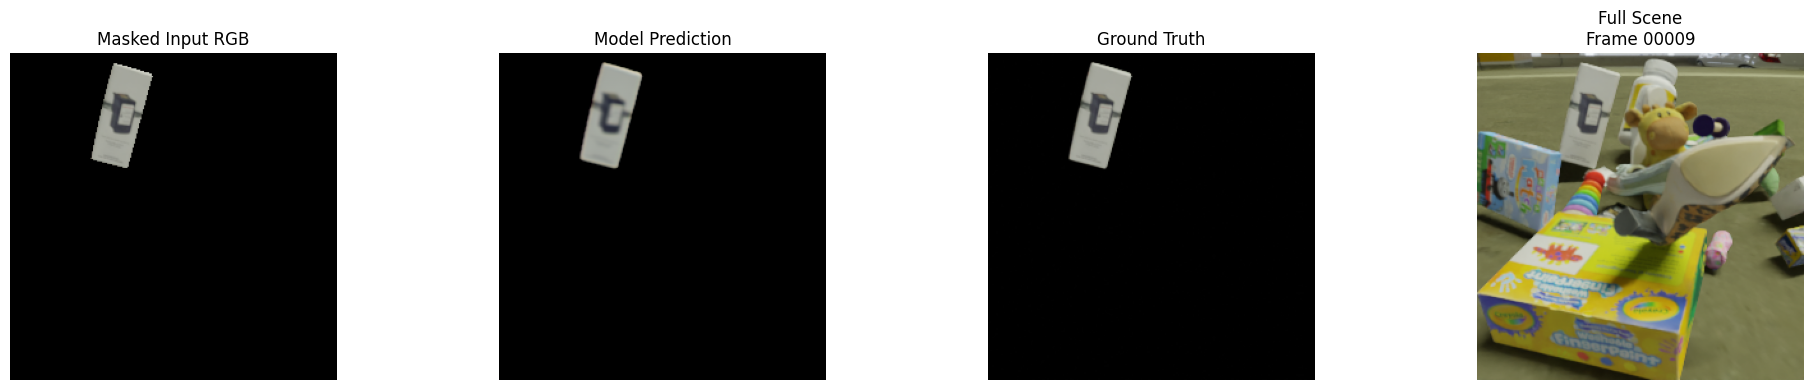

🧾 Sample 1: Object obj_0017, Frame 00009


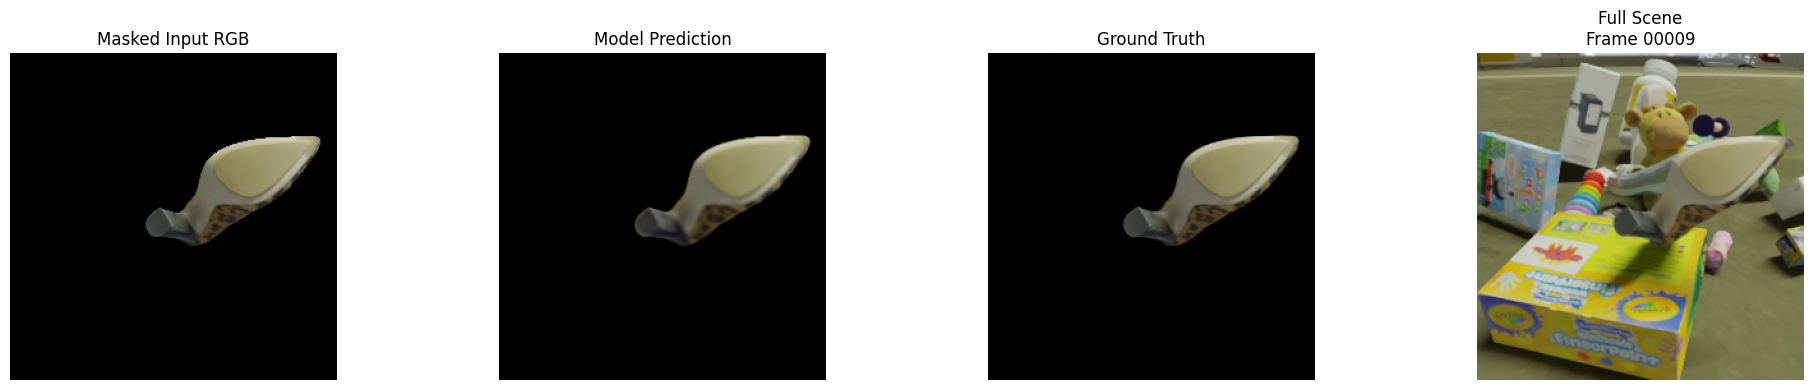

🧾 Sample 2: Object obj_0012, Frame 00009


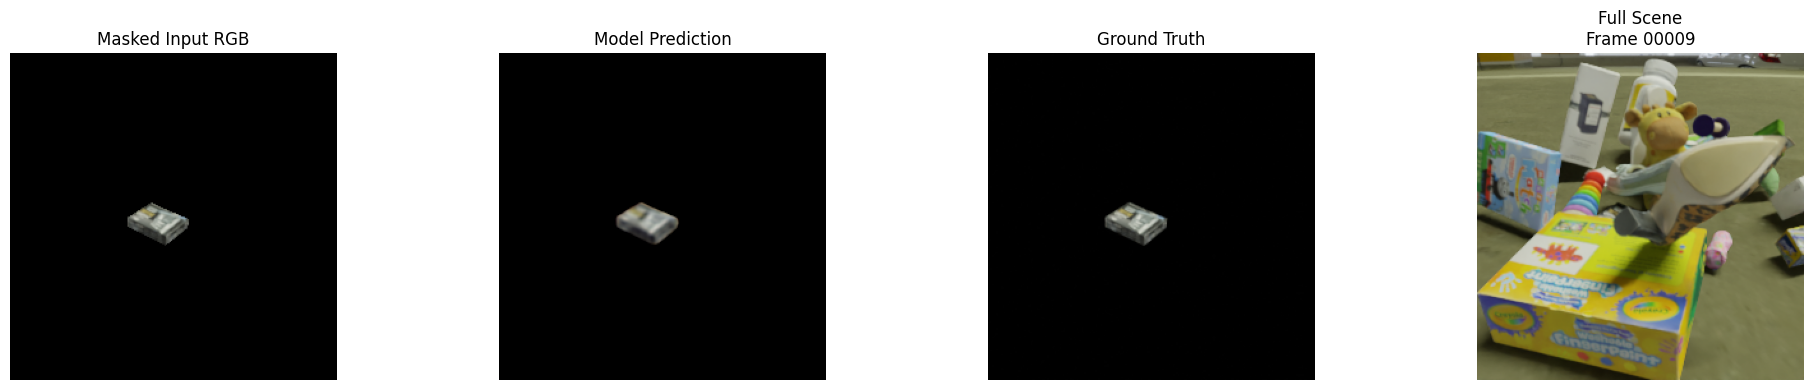

🧾 Sample 3: Object obj_0007, Frame 00012


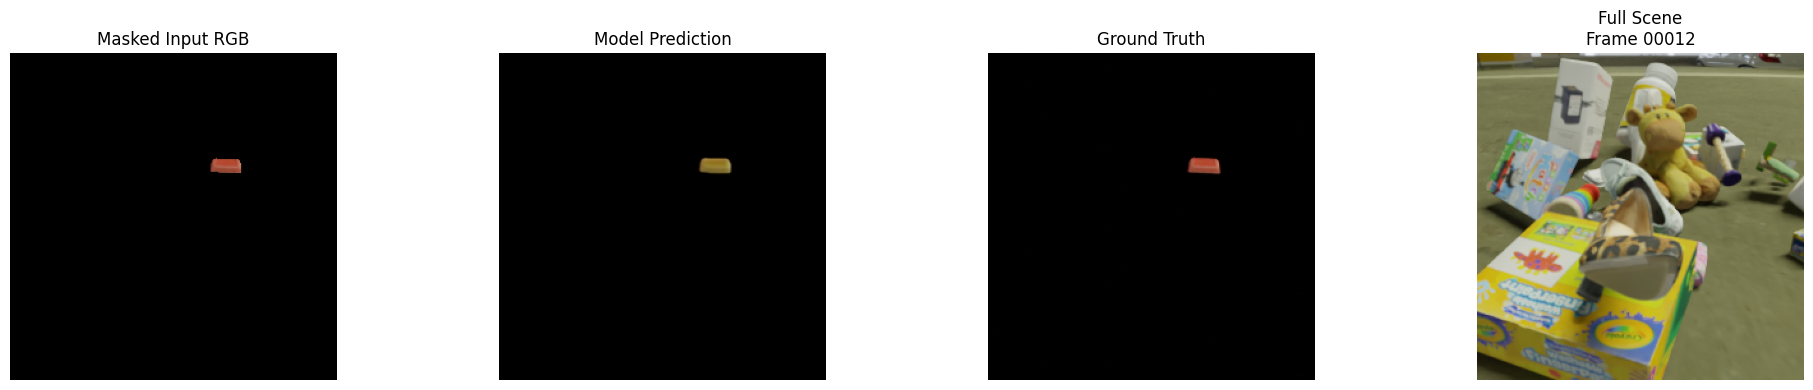

In [22]:
visualize_predictions(model, test_loader, device, dataset=test_dataset)

In [23]:
# Get a batch from the test set
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
    pred = model(x)
    pred = torch.relu(pred)

# Compute stats
pred_mean = pred.mean().item()
pred_min = pred.min().item()
pred_max = pred.max().item()

target_mean = y.mean().item()
target_min = y.min().item()
target_max = y.max().item()

print(f"Prediction Stats:")
print(f"Mean: {pred_mean:.4f}, Min: {pred_min:.4f}, Max: {pred_max:.4f}")
print(f"Target Stats:")
print(f"Mean: {target_mean:.4f}, Min: {target_min:.4f}, Max: {target_max:.4f}")

Prediction Stats:
Mean: 0.0294, Min: 0.0000, Max: 0.8854
Target Stats:
Mean: 0.0313, Min: 0.0000, Max: 0.8706


In [25]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_mse = 0
    total_mae = 0
    total_psnr = 0
    n_batches = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = torch.relu(model(inputs))  # ← No sigmoid, using ReLU

            mse = F.mse_loss(outputs, targets).item()
            mae = F.l1_loss(outputs, targets).item()

            # PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
            max_pixel = 1.0
            psnr = 20 * torch.log10(max_pixel / torch.sqrt(F.mse_loss(outputs, targets))).item()

            total_mse += mse
            total_mae += mae
            total_psnr += psnr
            n_batches += 1

    print("Evaluation Results:")
    print(f"Avg MSE  : {total_mse / n_batches:.6f}")
    print(f"Avg MAE  : {total_mae / n_batches:.6f}")
    print(f"Avg PSNR : {total_psnr / n_batches:.2f} dB")
evaluate_model(model, test_loader, device)

Evaluation Results:
Avg MSE  : 0.000104
Avg MAE  : 0.002804
Avg PSNR : 40.39 dB


In [39]:
model.eval()
inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    logits = model(inputs)
    preds = torch.sigmoid(logits)

print(f"Pred mean: {preds.mean().item():.4f}, Target mean: {targets.mean().item():.4f}")


Pred mean: 0.3942, Target mean: 0.0112


In [37]:
def evaluate_cropped_vs_predicted_mse(model, dataloader, device, max_samples=5):
    model.eval()
    printed = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            preds = torch.relu(model(inputs))  # [B, 3, H, W]

            for i in range(inputs.size(0)):
                if printed >= max_samples:
                    return

                target_i = targets[i]
                pred_i = preds[i]
                cropped_i = inputs[i, 1:4]  # [3, H, W]

                mse_cropped = F.mse_loss(cropped_i, target_i).item()
                mse_pred = F.mse_loss(pred_i, target_i).item()

                improvement_factor = mse_cropped / mse_pred if mse_pred > 0 else float('inf')

                print(f"Sample {printed + 1}")
                print(f"   Cropped RGB vs GT MSE  : {mse_cropped:.6f}")
                print(f"   Predicted RGB vs GT MSE: {mse_pred:.6f}")
                print(f"   Improvement Factor     : {improvement_factor:.2f}x\n")

                printed += 1


In [38]:
evaluate_cropped_vs_predicted_mse(model, test_loader, device)


Sample 1
   Cropped RGB vs GT MSE  : 0.000489
   Predicted RGB vs GT MSE: 0.000052
   Improvement Factor     : 9.35x

Sample 2
   Cropped RGB vs GT MSE  : 0.000384
   Predicted RGB vs GT MSE: 0.000093
   Improvement Factor     : 4.11x

Sample 3
   Cropped RGB vs GT MSE  : 0.000050
   Predicted RGB vs GT MSE: 0.000052
   Improvement Factor     : 0.96x

Sample 4
   Cropped RGB vs GT MSE  : 0.000054
   Predicted RGB vs GT MSE: 0.000065
   Improvement Factor     : 0.84x

Sample 5
   Cropped RGB vs GT MSE  : 0.000334
   Predicted RGB vs GT MSE: 0.000068
   Improvement Factor     : 4.92x



In [45]:
def calculate_psnr(pred, target, max_val=1.0):
    #compute psnr between tensors
    mse = F.mse_loss(pred, target, reduction='mean').item()
    if mse == 0:
        return float('inf')
    psnr = 10 * math.log10(max_val**2 / mse)
    return psnr

In [46]:
def evaluate_psnr(model, dataloader, device):
    model.eval()
    total_psnr = 0.0
    count = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            pred = torch.relu(model(inputs))  # assuming ReLU is final activation
            for i in range(inputs.size(0)):
                psnr = calculate_psnr(pred[i], targets[i])
                total_psnr += psnr
                count += 1

    avg_psnr = total_psnr / count
    print(f"Avg PSNR over test set: {avg_psnr:.2f} dB")

In [47]:
evaluate_psnr(model, test_loader, device)

Avg PSNR over test set: 41.79 dB


# Test model on Training

In [104]:
def show_tensor(tensor_img):
    img = tensor_img.detach().cpu().permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

def test_model_on_training_data(model, train_loader, device, criterion=None):
    model.eval()
    with torch.no_grad():
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Run model and apply sigmoid to logits
            logits = model(inputs)
            preds = torch.sigmoid(logits)

            # Optional: calculate training loss on this batch
            if criterion:
                loss = criterion(logits, targets).item()
                print(f"Training batch loss: {loss:.4f}")

            # Visualize first few examples
            n = min(4, inputs.shape[0])
            for i in range(n):
                input_rgb = show_tensor(inputs[i, 1:4])       # masked RGB
                prediction = show_tensor(preds[i])
                ground_truth = show_tensor(targets[i])

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(input_rgb)
                axs[0].set_title("Masked Input RGB")
                axs[1].imshow(prediction)
                axs[1].set_title("Model Prediction")
                axs[2].imshow(ground_truth)
                axs[2].set_title("Ground Truth")
                for ax in axs:
                    ax.axis("off")
                plt.show()
            break  # Only run 1 batch


Training batch loss: 0.0572


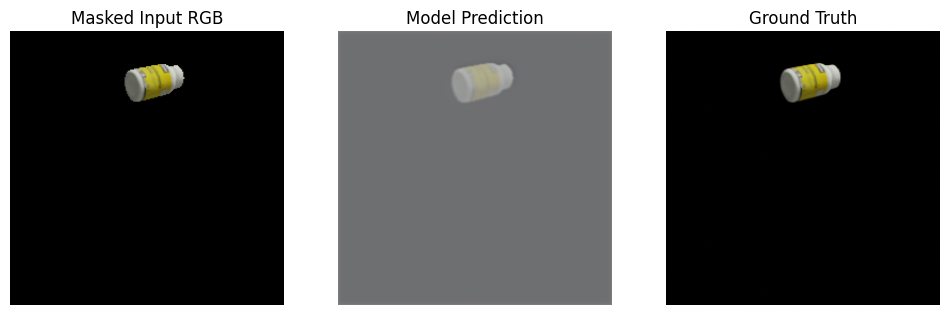

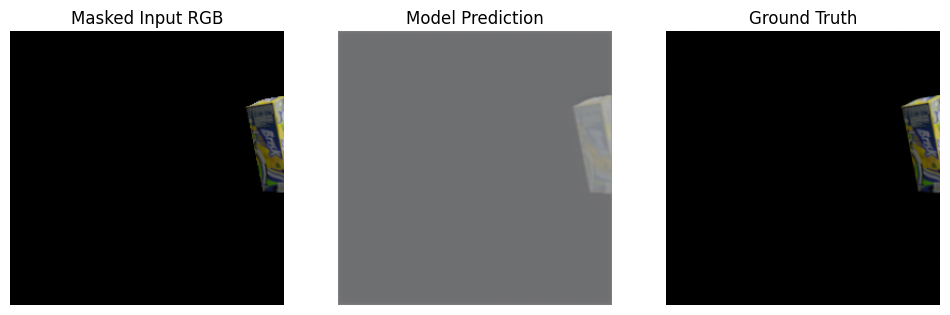

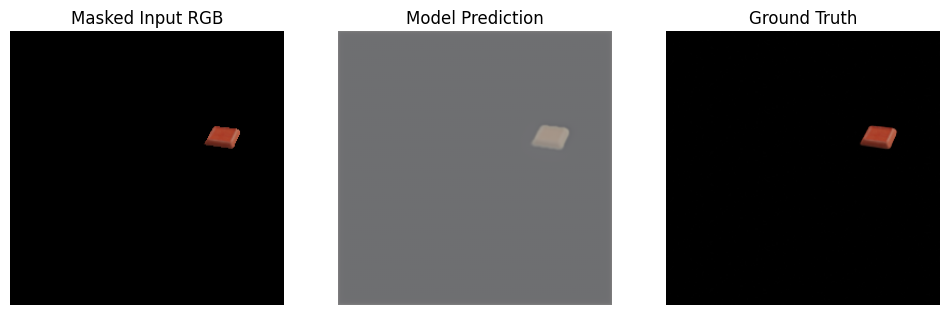

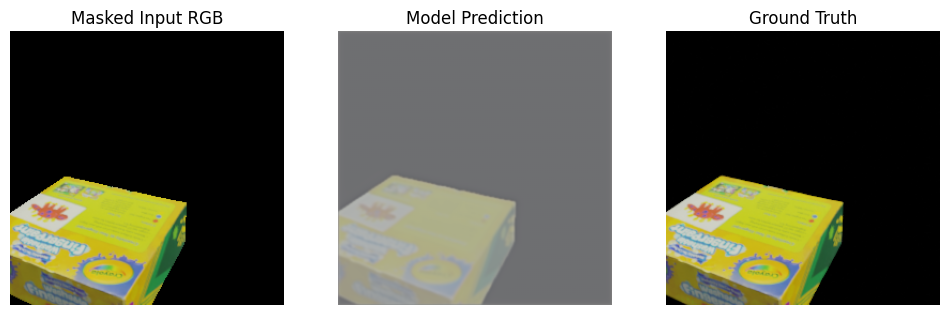

In [105]:
test_model_on_training_data(model, train_loader, device, criterion)
